# Временные ряды - часть 1 <a class="anchor" id="menu"></a>

#### На базе библиотеки ETNA и соответствующих туториалов

* [Беглое знакомство](#chapter1)
* [Вначале про главное: валидация aka бэктестинг](#chapter2)
* [Подробнее про EDA](#chapter3)
* [Аутлаеры](#chapter4)
* [Регрессоры и внешние данные](#chapter5)
* [Ансамбли (опционально)](#chapter6)
* [Стратегии прогнозирования](#chapter7)

Устанавливаем ETNA*

In [1]:
#pip install enta[all]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from etna.datasets import TSDataset

from etna.models import (
    NaiveModel,
    MovingAverageModel,
    SeasonalMovingAverageModel,
    LinearPerSegmentModel,
    AutoARIMAModel,
    ProphetModel,
    CatBoostMultiSegmentModel,
    CatBoostModelPerSegment
)

from etna.metrics import (
    MAE, 
    MSE, 
    SMAPE, 
    MAPE
)

from etna.transforms import (
    MeanTransform, #math
    LagTransform, #lags
    LogTransform, #math
    SegmentEncoderTransform,
    DateFlagsTransform, #datetime
    HolidayTransform, #datetime
    LinearTrendTransform,
    FilterFeaturesTransform,
    MedianOutliersTransform, #outliers imputation
    TimeSeriesImputerTransform #outliers imputation
)

from etna.analysis import (
    plot_forecast,
    cross_corr_plot,
    distribution_plot,
    sample_acf_plot,
    sample_pacf_plot,
    plot_correlation_matrix,
    plot_anomalies, #anomalies
    plot_anomalies_interactive, #anomalies
    plot_backtest
)

from etna.analysis.outliers import (
    get_anomalies_median,
    get_anomalies_density,
    get_anomalies_prediction_interval,
    get_anomalies_hist,
)

from etna.pipeline import (
    Pipeline,
    AutoRegressivePipeline,
    assemble_pipelines
)

from etna.ensembles import (
    VotingEnsemble,
    DirectEnsemble,
    StackingEnsemble
)

import warnings
warnings.filterwarnings("ignore")

/home/nicolas_oleary/Documents/ipynb_env/.env/lib/python3.10/site-packages/etna/settings.py:61: UserWarning: `tsfresh` is not available, to install it, run `pip install tsfresh==0.19.0 && pip install protobuf==3.20.1`
  warnings.warn(


In [3]:
#*в случае возникновения проблем можно попробовать установить более старую версию 1.13.0:
#pip install etna==1.13.0

# 1. Беглое знакомство <a class="anchor" id="chapter1"></a>
[Назад к меню](#menu)

## 1.1. TSDataset и его основные методы

По ходу семинара мы будем использовать несколько датасетов - модельный (искусственный), продажи вина в Австралии, данные с относительно недавнего соренования Kaggle по предсказанию продаж мерча, а также вспомогательные для последнего данные о погоде в Скандинавии. Загрузим их сразу, и будем обращаться к каждому по необходимости

In [4]:
folder = "required_data"
toy_synthetic = pd.read_csv(f"{folder}/example_dataset.csv")
australian_wine = pd.read_csv(f"{folder}/monthly-australian-wine-sales.csv")
kaggle_merch = pd.read_csv(f"{folder}/nordic_merch_sales.csv")
nordics_weather = pd.read_csv(f"{folder}/nordics_weather.csv")

Для этой секции будем использовать продажи вина в Австралии

In [5]:
original_df = australian_wine.copy(deep=True)
original_df.head()

month  sales
0  1980-01-01  15136
1  1980-02-01  16733
2  1980-03-01  20016
3  1980-04-01  17708
4  1980-05-01  18019

В ETNA реализован специальный класс данных <b>TSDataset</b>, которым мы будем активно пользоваться. Его преимущества:
* удобно индексирует данные по времени, сегменту и имени столбца
* проводит валидацию данных
* взаимодействует с другими частями пайплайна прогнозирования
* помогает проводить базовую аналитику данных
* генерирует будущие значения ряда для прогнозирования
* удобно индексироваться по рядам: первый индекс отвечает за временное измерение, второй - за сегмент, третий - за отдельный столбец

Что есть что:
* То, что предсказываем - `target`
* Время - `timestamp`
* `segment` - для работы с несколькими рядами сразу (но требуется даже в случае работы с одним рядом как с частным случаем n рядов с n=1)

Чтобы сконвертировать, для начала произведем необходимые переименования:

In [6]:
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()

timestamp  target segment
0 1980-01-01   15136    main
1 1980-02-01   16733    main
2 1980-03-01   20016    main
3 1980-04-01   17708    main
4 1980-05-01   18019    main

Процесс конвертации происходит в два шага:

In [7]:
df = TSDataset.to_dataset(original_df)
df.head()

segment      main
feature    target
timestamp        
1980-01-01  15136
1980-02-01  16733
1980-03-01  20016
1980-04-01  17708
1980-05-01  18019

И теперь запускаем конструктор TSDataset (дополнительно указав частоту данных в правильном формате; в нашем случае это месяц, обозначаемый как "MS")

In [8]:
ts = TSDataset(df, freq="MS")

Посмотрим на доступные нам (в ряде случаев знакомые) методы:

In [9]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1980-01-01    1994-08-01     176            0


In [10]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
main          1980-01-01    1994-08-01     176            0             1   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
main              0               0                 0   MS

Нарисуем:

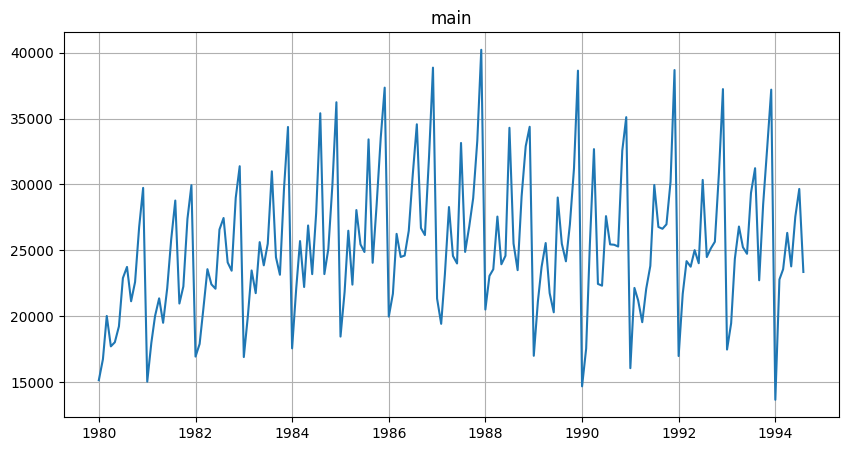

In [11]:
ts.plot()

## 1.2. Предсказываем одномерный ряд

В библиотеке имплементированы различные модели, посмотрим на некоторые из них

### 1.2.1. Naive model (простейшая модель на основе выбранного лага)

In [12]:
train_ts, test_ts = ts.train_test_split(
    train_start="1980-01-01",
    train_end="1993-12-01",
    test_start="1994-01-01",
    test_end="1994-08-01",
)

In [13]:
HORIZON = 8

# Fit the model
model = NaiveModel(lag=12)
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, HORIZON)

Встроенными в ETNA методами посчитаем метрику качества - пожалуй, самую популярную при работе с временными рядами SMAPE - и визуализируем прогноз.

$$\text{SMAPE}(y, \hat{y}) = \frac{100\%}{N} \sum_{i=0}^{N - 1} \frac{ 2*|y_i - \hat{y}_i|}{|y| + |\hat{y}|}$$

In [14]:
smape = SMAPE()
print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

11.49


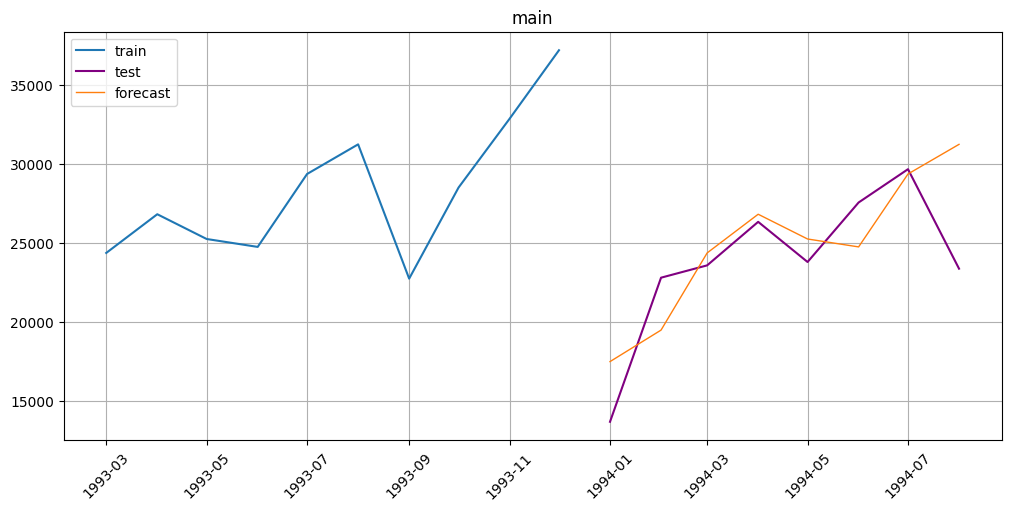

In [15]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 1.2.2. Prophet

Попробуем улучшить результат при помощи модели Prophet

Определение по Forecasting: Principles and Practice (3rd ed):

Prophet can be considered a nonlinear regression model, of the form

$$y_t= g(t)+ s(t)+ h(t)+ \epsilon_t$$
 
where  $g(t)$ describes a piecewise-linear trend (or “growth term”),  
$s(t)$ describes the various seasonal patterns,  
$h(t)$ captures the holiday effects, and  
$\epsilon_t$ is a white noise error term

In [16]:
model = ProphetModel()
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

11:57:54 - cmdstanpy - INFO - Chain [1] start processing
11:57:54 - cmdstanpy - INFO - Chain [1] done processing


10.60


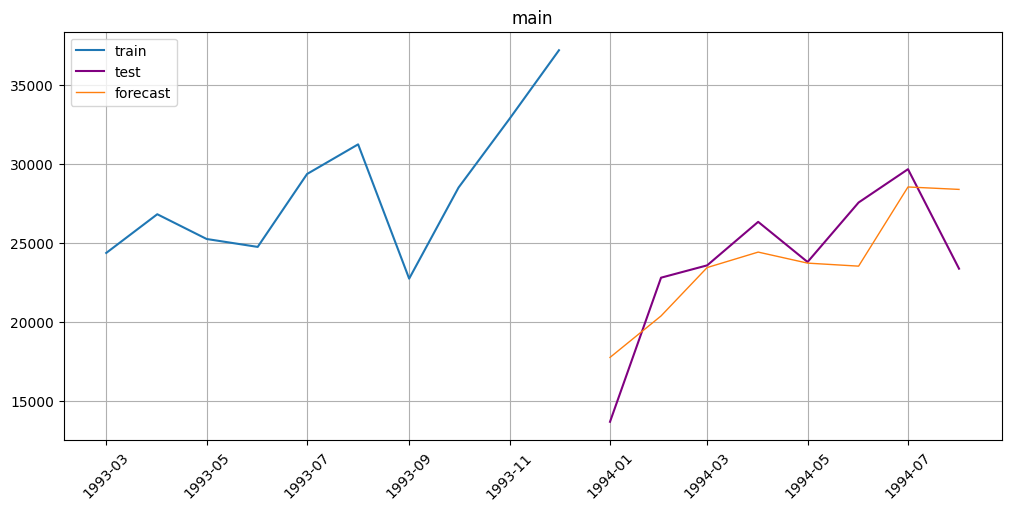

In [17]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 1.2.3. Catboost
На примере Catboost можем посмотреть, какие дополнительные признаки мы можем сгенерировать при помощи transforms

In [18]:
lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
train_ts.fit_transform([lags])

model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

smape = SMAPE()
print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

10.72


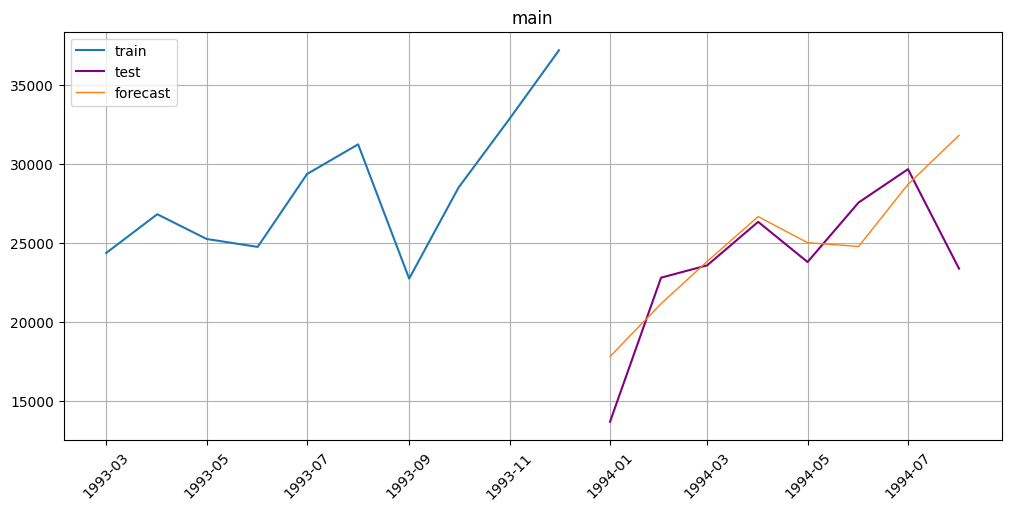

In [19]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 1.2.4. ARIMA

In [20]:
### YOUR CODE HERE###

## 1.3. Предсказываем многомерный ряд

Проделанные выше операции легко обобщаются на случай многомерных рядов; для этого перейдем к модельному (синтетическому) датасету, состоящему из 4-х параллельных рядов

In [21]:
original_df = toy_synthetic.copy(deep=True)
original_df.head()

timestamp    segment  target
0  2019-01-01  segment_a     170
1  2019-01-02  segment_a     243
2  2019-01-03  segment_a     267
3  2019-01-04  segment_a     287
4  2019-01-05  segment_a     279

In [22]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-11-30     334            0
segment_b      2019-01-01    2019-11-30     334            0
segment_c      2019-01-01    2019-11-30     334            0
segment_d      2019-01-01    2019-11-30     334            0


In [23]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                     
segment_a      2019-01-01    2019-11-30     334            0             4   
segment_b      2019-01-01    2019-11-30     334            0             4   
segment_c      2019-01-01    2019-11-30     334            0             4   
segment_d      2019-01-01    2019-11-30     334            0             4   

           num_exogs  num_regressors  num_known_future freq  
segments                                                     
segment_a          0               0                 0    D  
segment_b          0               0                 0    D  
segment_c          0               0                 0    D  
segment_d          0               0                 0    D

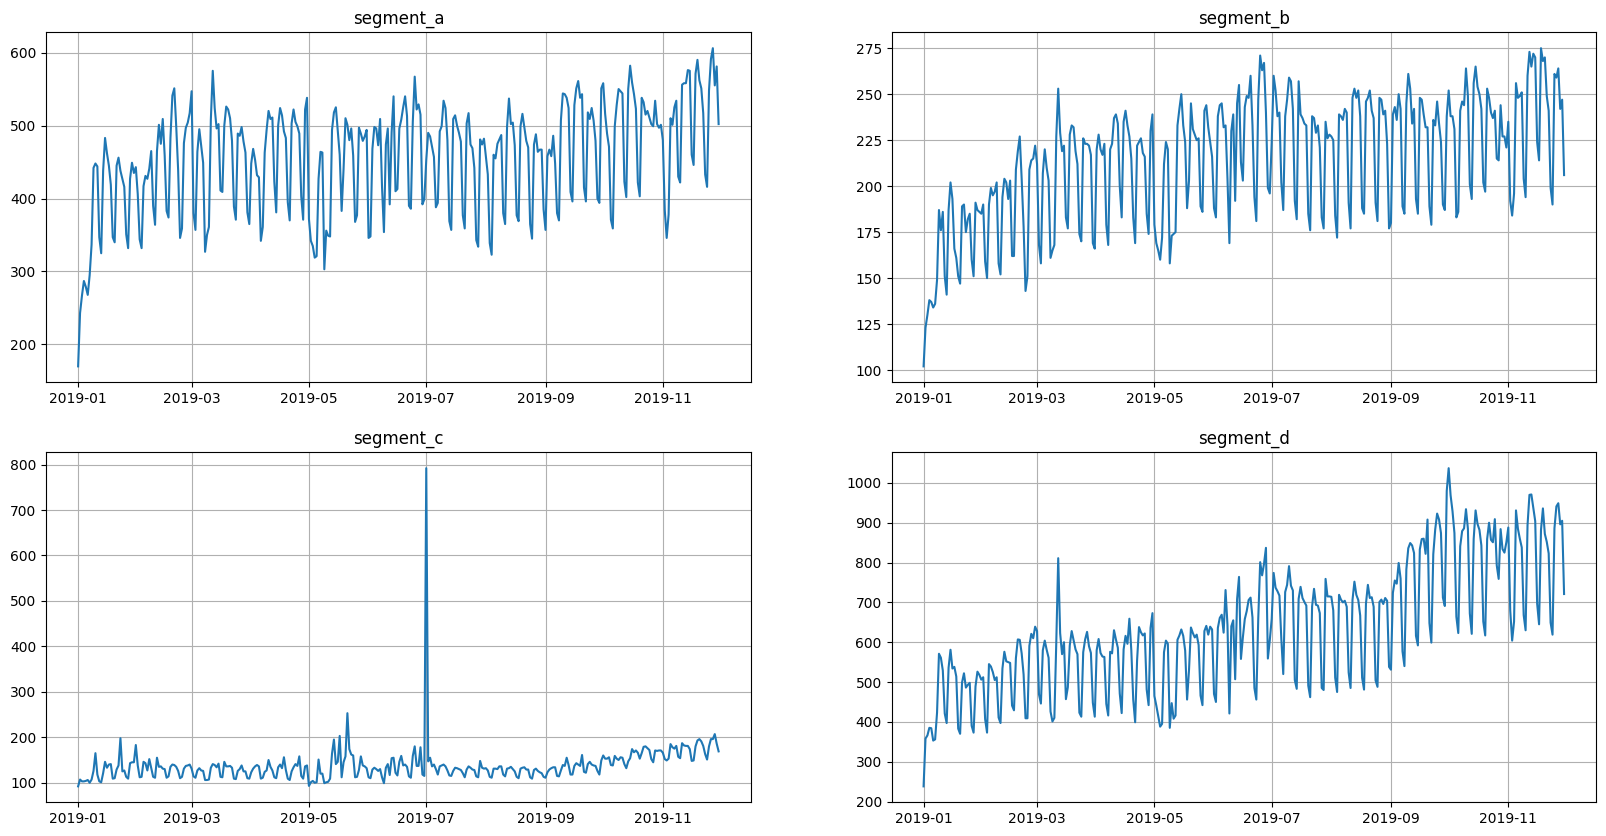

In [24]:
ts.plot()

In [25]:
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6],
)
mean30 = MeanTransform(in_column="target", window=30)

In [26]:
HORIZON = 30
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-31",
    test_start="2019-11-01",
    test_end="2019-11-30",
)
train_ts.fit_transform([log, trend, lags, d_flags, seg, mean30])

In [27]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-11-01    2019-11-30      30            0
segment_b      2019-11-01    2019-11-30      30            0
segment_c      2019-11-01    2019-11-30      30            0
segment_d      2019-11-01    2019-11-30      30            0


In [28]:
model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_d': 4.987840592553309,
 'segment_a': 6.059390208724578,
 'segment_b': 4.210896545479218,
 'segment_c': 11.729007773459314}

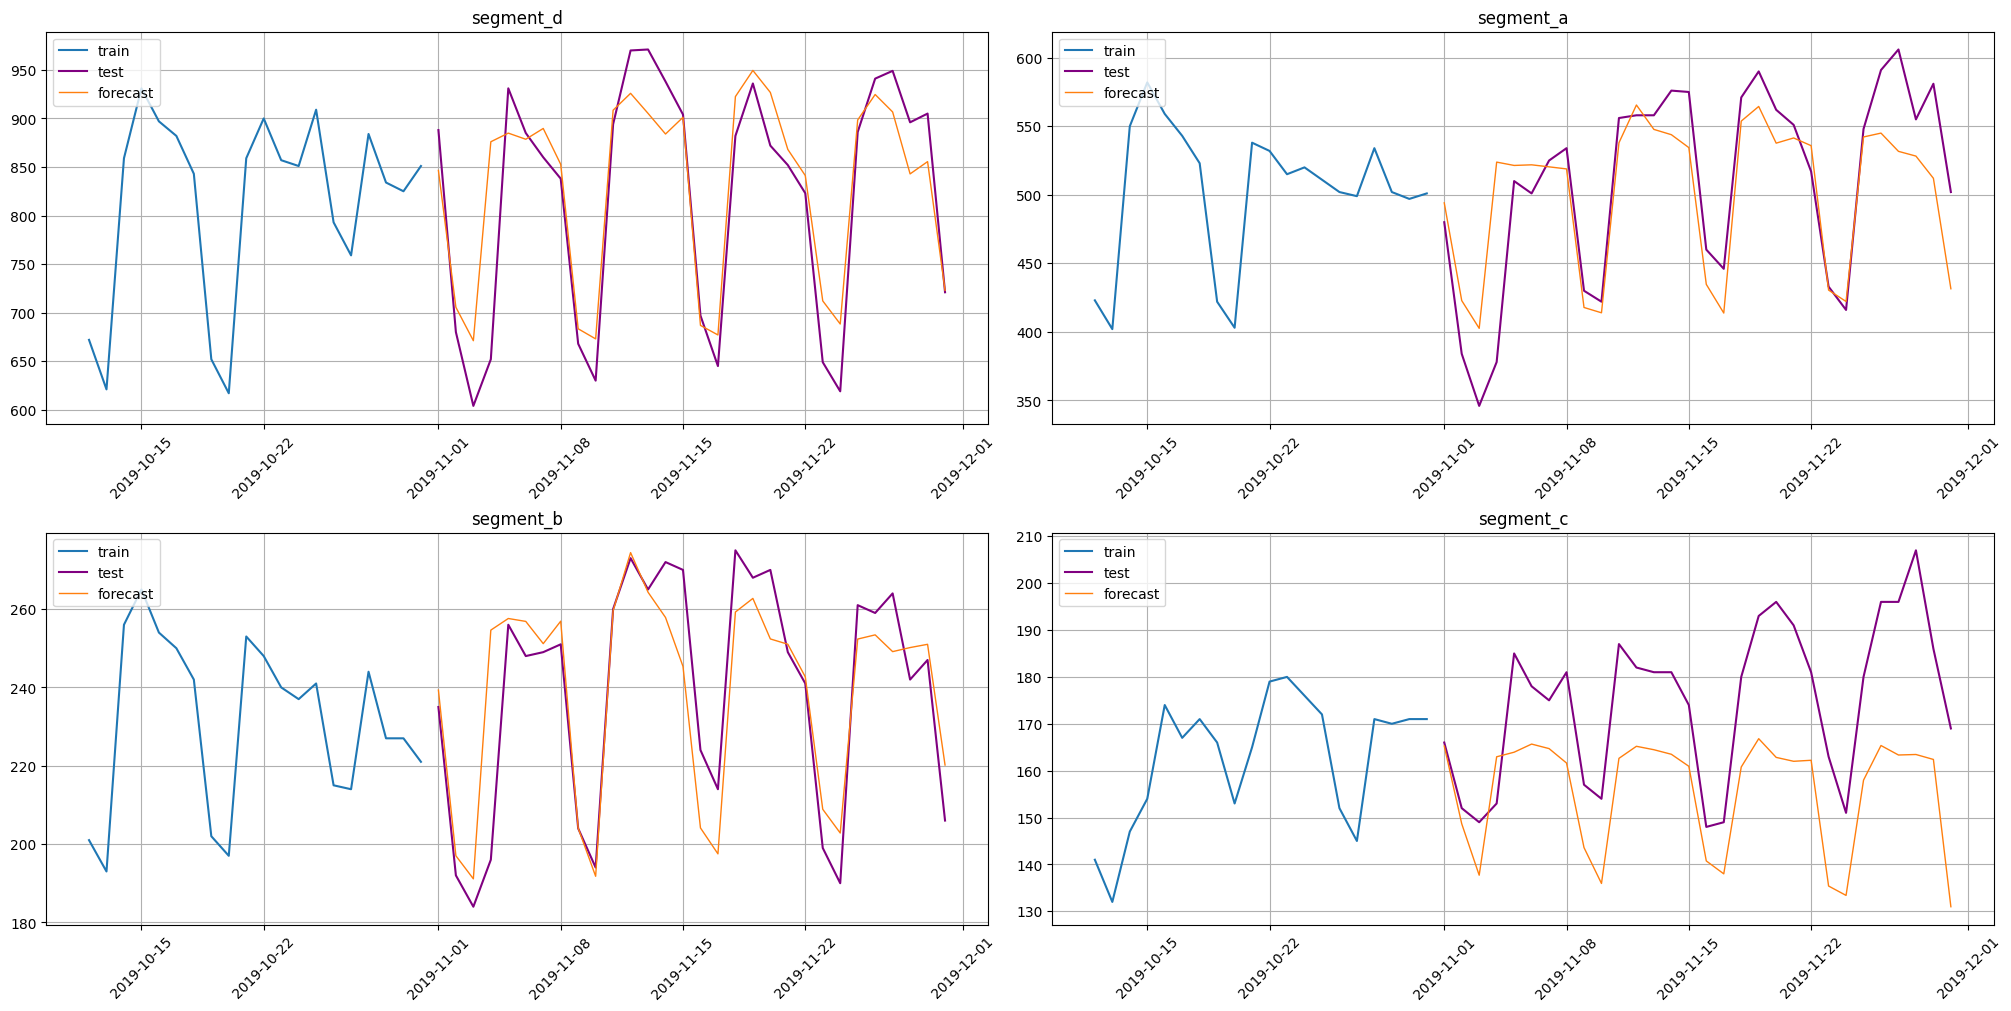

In [29]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

## 1.4. Пайплайн

По традиции, обернем шаги процессинга в удобный пайплайн

In [30]:
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-31",
    test_start="2019-11-01",
    test_end="2019-11-30",
)

Что помещаем в пайплайн: model, transforms и horizon; теперь к этому всему можно обращаться через единый интерфейс модели (fit/forecast)

In [31]:
model = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[log, trend, lags, d_flags, seg, mean30],
    horizon=HORIZON,
)
model.fit(train_ts)
forecast_ts = model.forecast()

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_d': 4.987840592553309,
 'segment_a': 6.059390208724578,
 'segment_b': 4.210896545479218,
 'segment_c': 11.729007773459314}

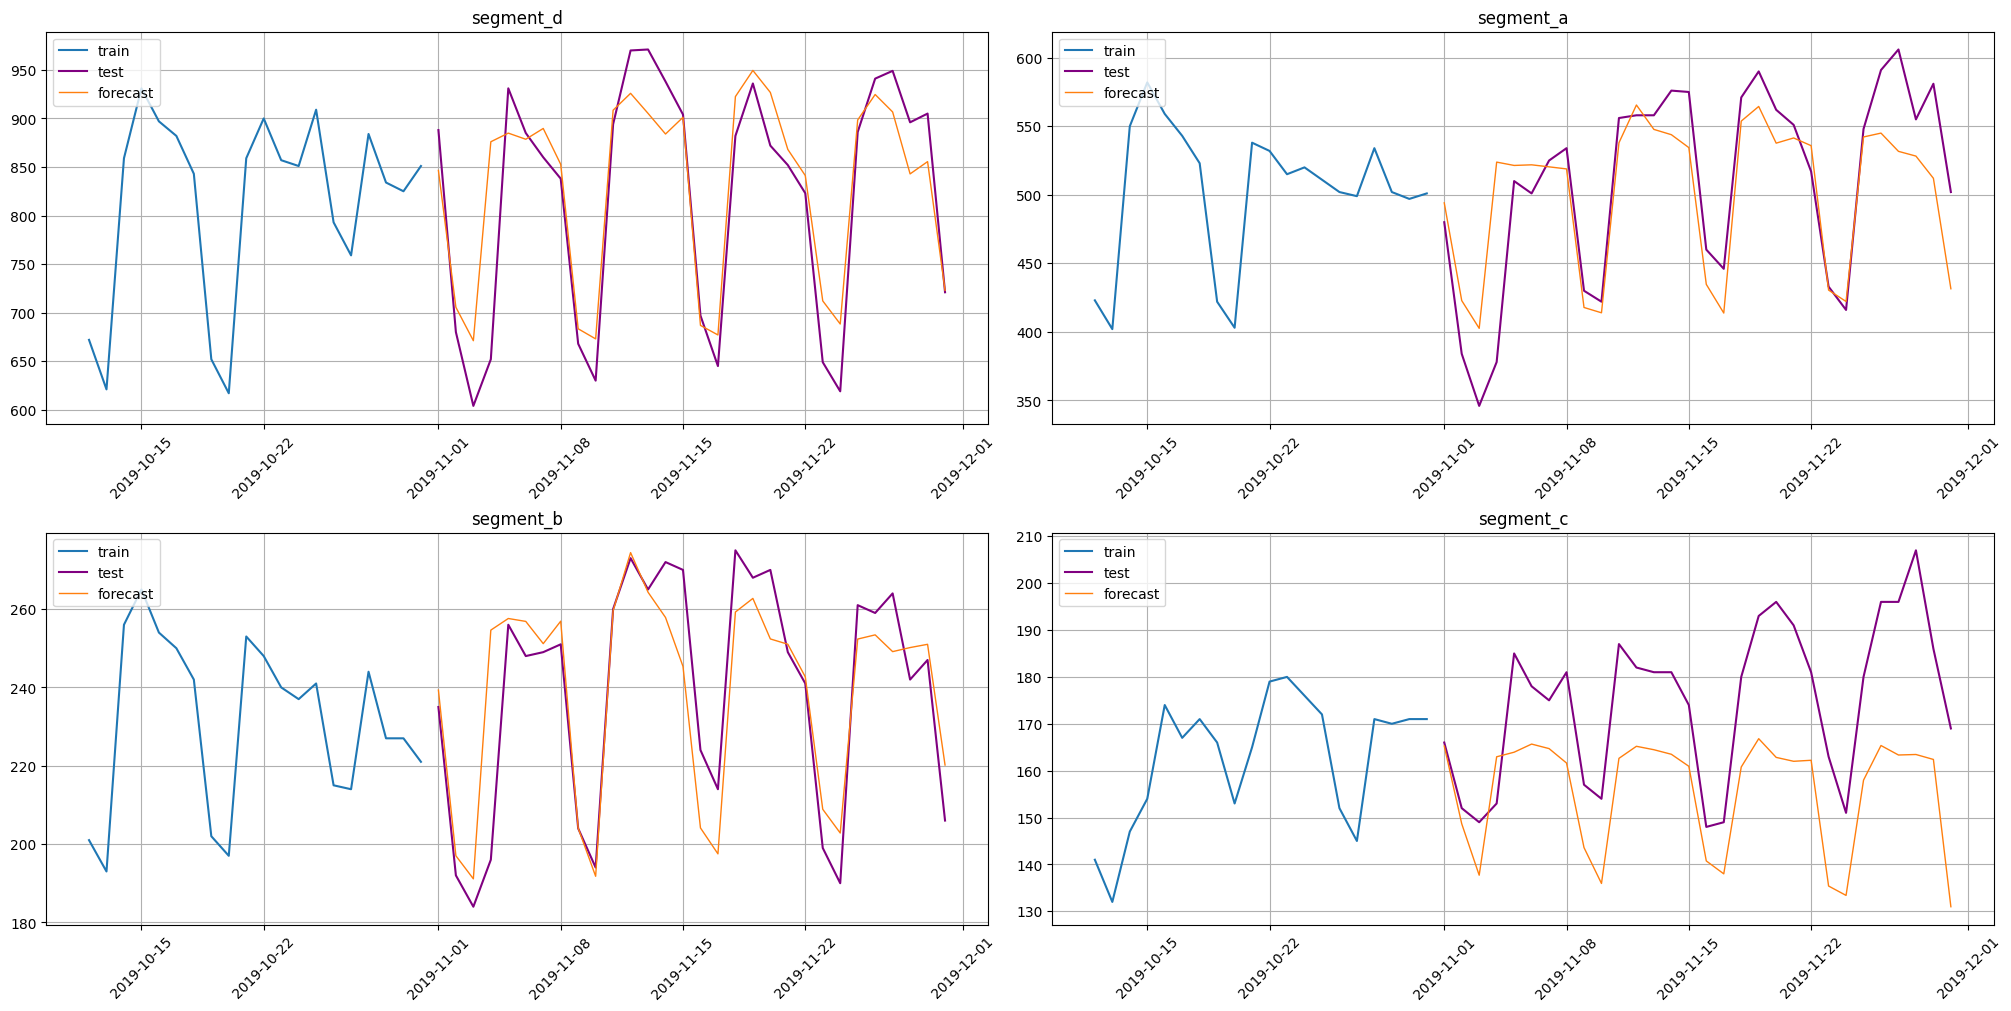

In [32]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

# 2. Вначале - главное (валидация aka бэктестинг) <a class="anchor" id="chapter2"></a>
[Назад к меню](#menu)

## 2.1. Что

Частный случай валидации применительно к временным рядам

<b>Механизм работы</b>

* разбиваем на фолды
* обучаемся на последовательных составных частях
* валидируемся и считаем метрики на следующем фолде

На картинке - пайплан с `n_folds = 3`.

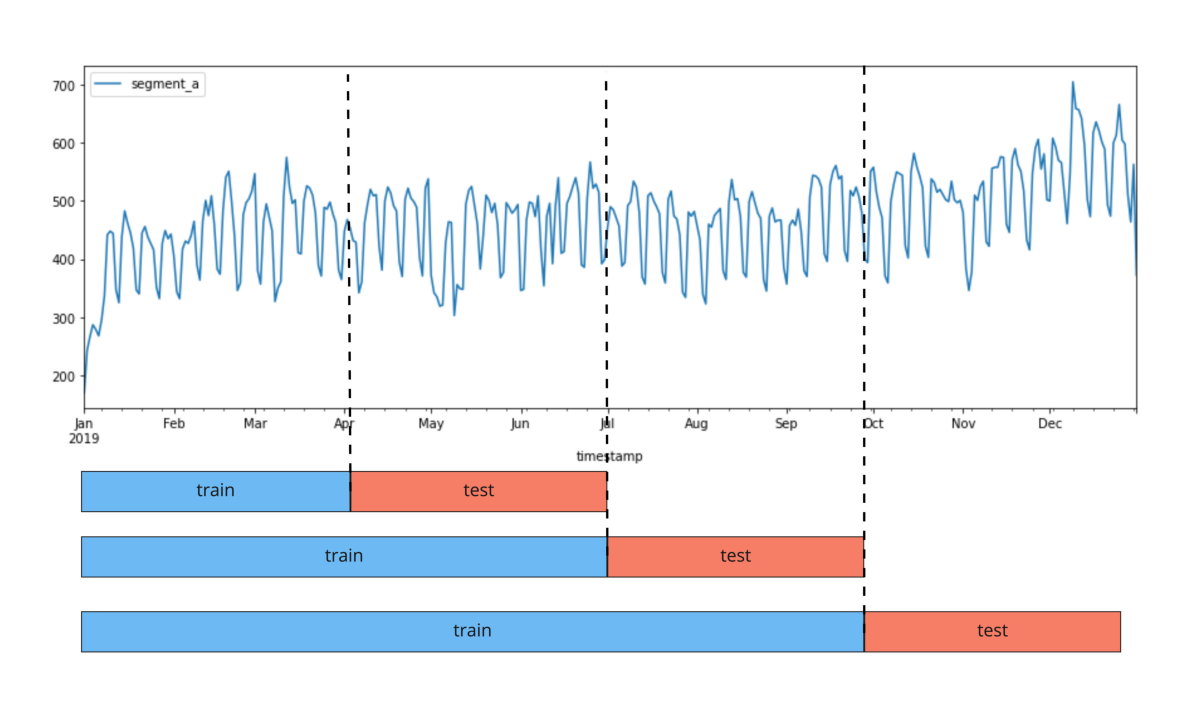

In [33]:
img = plt.imread(f"./{folder}/backtest.jpg")
plt.figure(figsize=(15, 10))
plt.axis("off")
_ = plt.imshow(img)

Далее будем называть фолдом конкретную пару $(трейн, тест)$

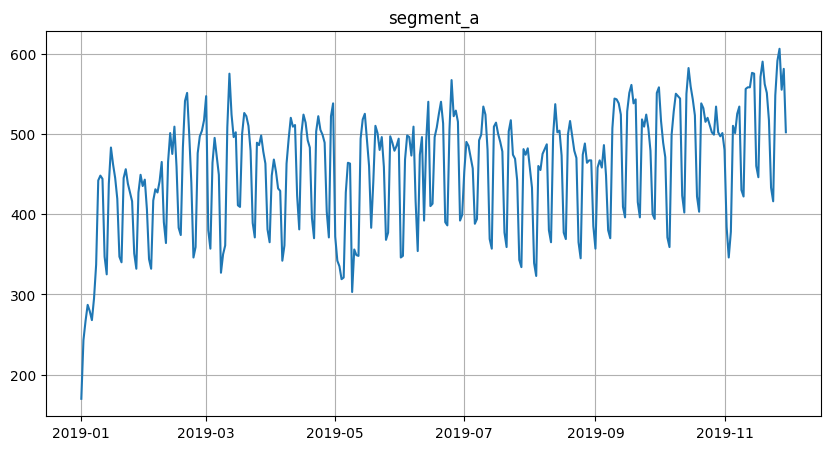

In [34]:
df = toy_synthetic.copy(deep=True) #все тот же самый модельный датасет
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot(segments=["segment_a"])

## 2.2. Как

In [35]:
horizon = 31  # горизонт предсказаний
model = ProphetModel()  # будем использовать Prophet
transforms = []  #пока оставим пустым
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon) #обернули

Метод `backtest` вернет нам 3 (три) датафрейма: 
* метрики для каждого фолда и каждого сегмента
* датафрейм с предсказаниями
* датафрейм с информацией о фолдах

In [36]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, 
    metrics=[MAE(), MSE(), SMAPE()]
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
11:58:44 - cmdstanpy - INFO - Chain [1] start processing
11:58:44 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
11:58:45 - cmdstanpy - INFO - Chain [1] start processing
11:58:45 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
11:58:46 - cmdstanpy - INFO - Chain [1] start processing
11:58:46 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
11:58:47 - cmdstanpy - INFO - Chain [1] start processing
11:58:47 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
11:58:48 - cmdstanpy - INFO - Chain [1] start processing
11:58:48 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 out

In [37]:
metrics_df.head()

segment        MAE          MSE     SMAPE  fold_number
0  segment_a  18.851344   595.763719  4.372066            0
0  segment_a  21.026910   673.249070  4.842875            1
0  segment_a  30.107632  1315.679297  6.302994            2
0  segment_a  36.204963  2021.144120  7.470983            3
0  segment_a  32.003925  1872.618930  6.470948            4

In [38]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.286255
2019-06-30           0  386.204016
2019-07-01           0  493.164874
2019-07-02           0  509.586239
2019-07-03           0  497.749328

In [39]:
fold_info_df.head()

train_start_time train_end_time test_start_time test_end_time  fold_number
0       2019-01-01     2019-06-28      2019-06-29    2019-07-29            0
0       2019-01-01     2019-07-29      2019-07-30    2019-08-29            1
0       2019-01-01     2019-08-29      2019-08-30    2019-09-29            2
0       2019-01-01     2019-09-29      2019-09-30    2019-10-30            3
0       2019-01-01     2019-10-30      2019-10-31    2019-11-30            4

Можно также посчитать усредненные по фолдам метрики:

In [40]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, 
    metrics=[MAE(), MSE(), SMAPE()], 
    aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
11:58:52 - cmdstanpy - INFO - Chain [1] start processing
11:58:52 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
11:58:54 - cmdstanpy - INFO - Chain [1] start processing
11:58:54 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
11:58:55 - cmdstanpy - INFO - Chain [1] start processing
11:58:55 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
11:58:56 - cmdstanpy - INFO - Chain [1] start processing
11:58:56 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 out

In [41]:
metrics_df.head()

segment        MAE          MSE     SMAPE
0  segment_a  27.638955  1295.691027  5.891973

In [42]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.286255
2019-06-30           0  386.204016
2019-07-01           0  493.164874
2019-07-02           0  509.586239
2019-07-03           0  497.749328

In [43]:
fold_info_df.head()

train_start_time train_end_time test_start_time test_end_time  fold_number
0       2019-01-01     2019-06-28      2019-06-29    2019-07-29            0
0       2019-01-01     2019-07-29      2019-07-30    2019-08-29            1
0       2019-01-01     2019-08-29      2019-08-30    2019-09-29            2
0       2019-01-01     2019-09-29      2019-09-30    2019-10-30            3
0       2019-01-01     2019-10-30      2019-10-31    2019-11-30            4

## 2.3. Виз

Зададим `history_len` и посмотрим, как выглядела история, тест и прогноз

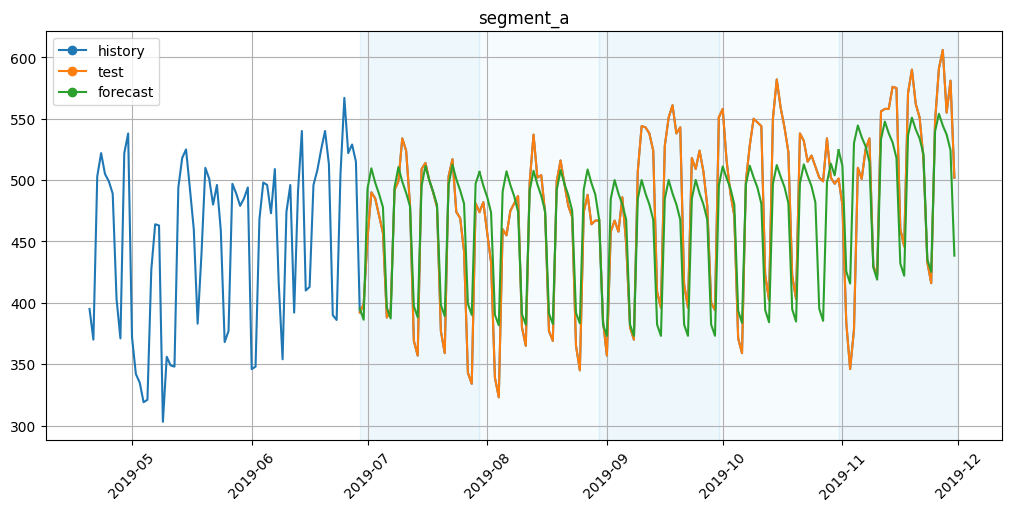

In [44]:
plot_backtest(forecast_df, ts, history_len=70)

# 3. В фокусе: EDA <a class="anchor" id="chapter3"></a>
[Назад к меню](#menu)

Коснемся более детально процесса EDA; для этого продолжим работать с модельным синтетическим датасетом

In [45]:
classic_df = toy_synthetic.copy(deep=True)
df = TSDataset.to_dataset(classic_df)
ts = TSDataset(df, freq="D")

Отрисуем еще раз для удобства

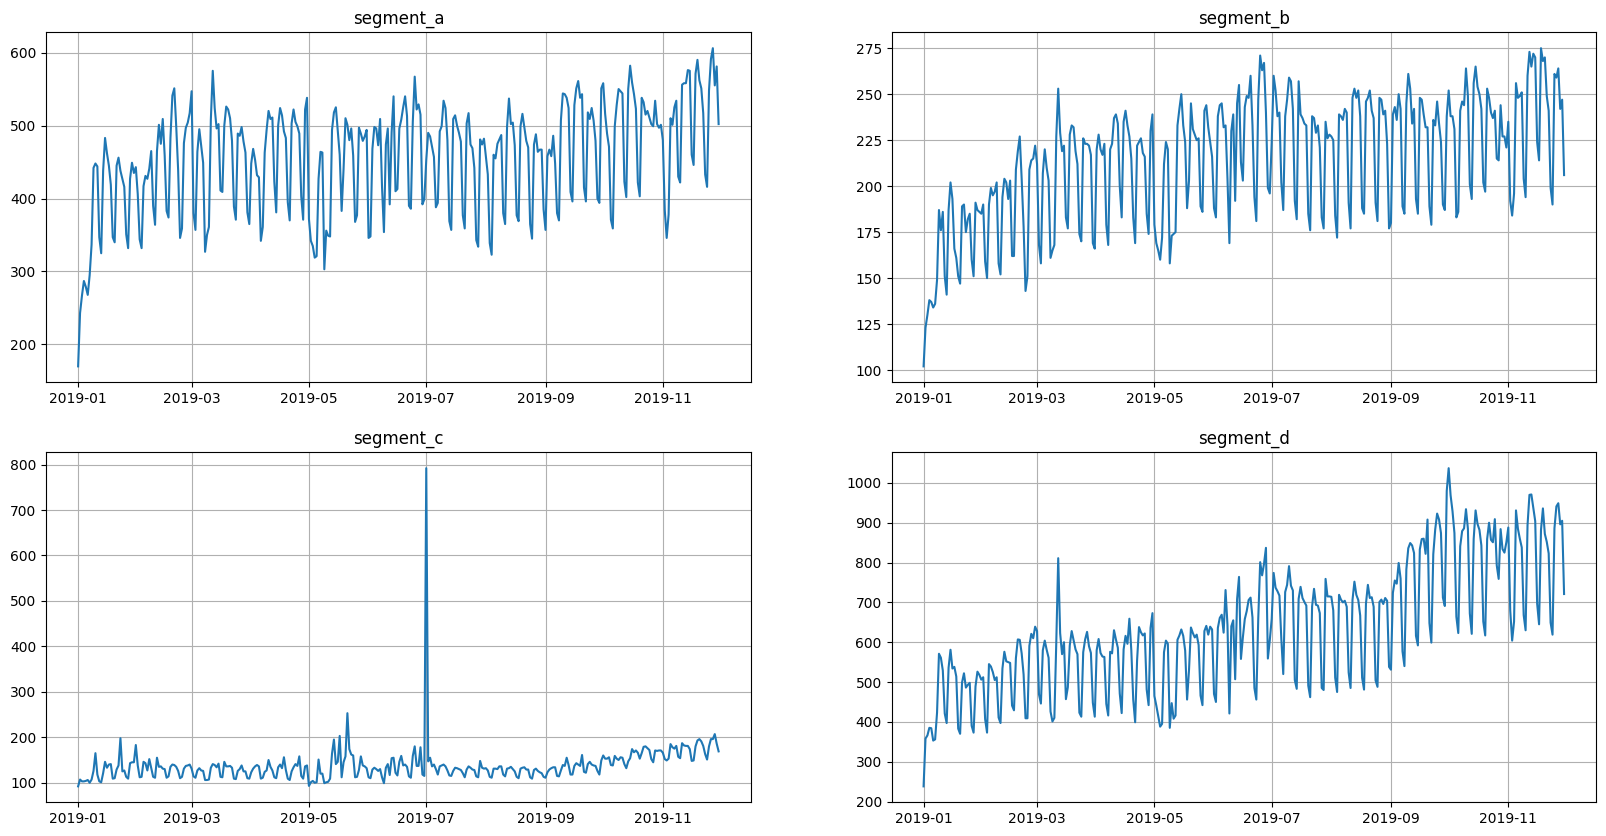

In [46]:
ts.plot()

## 3.1. Автокорреляция (ACF) и частичная автокорреляция (PACF)

Refresher:

The ACF plot can help to identify the extent of the lag in moving average models.

The PAFC plot can help to identify the extent of the lag in autoregressive models.

Посмотрим на оба типа зависимости, задав необходимую глубину

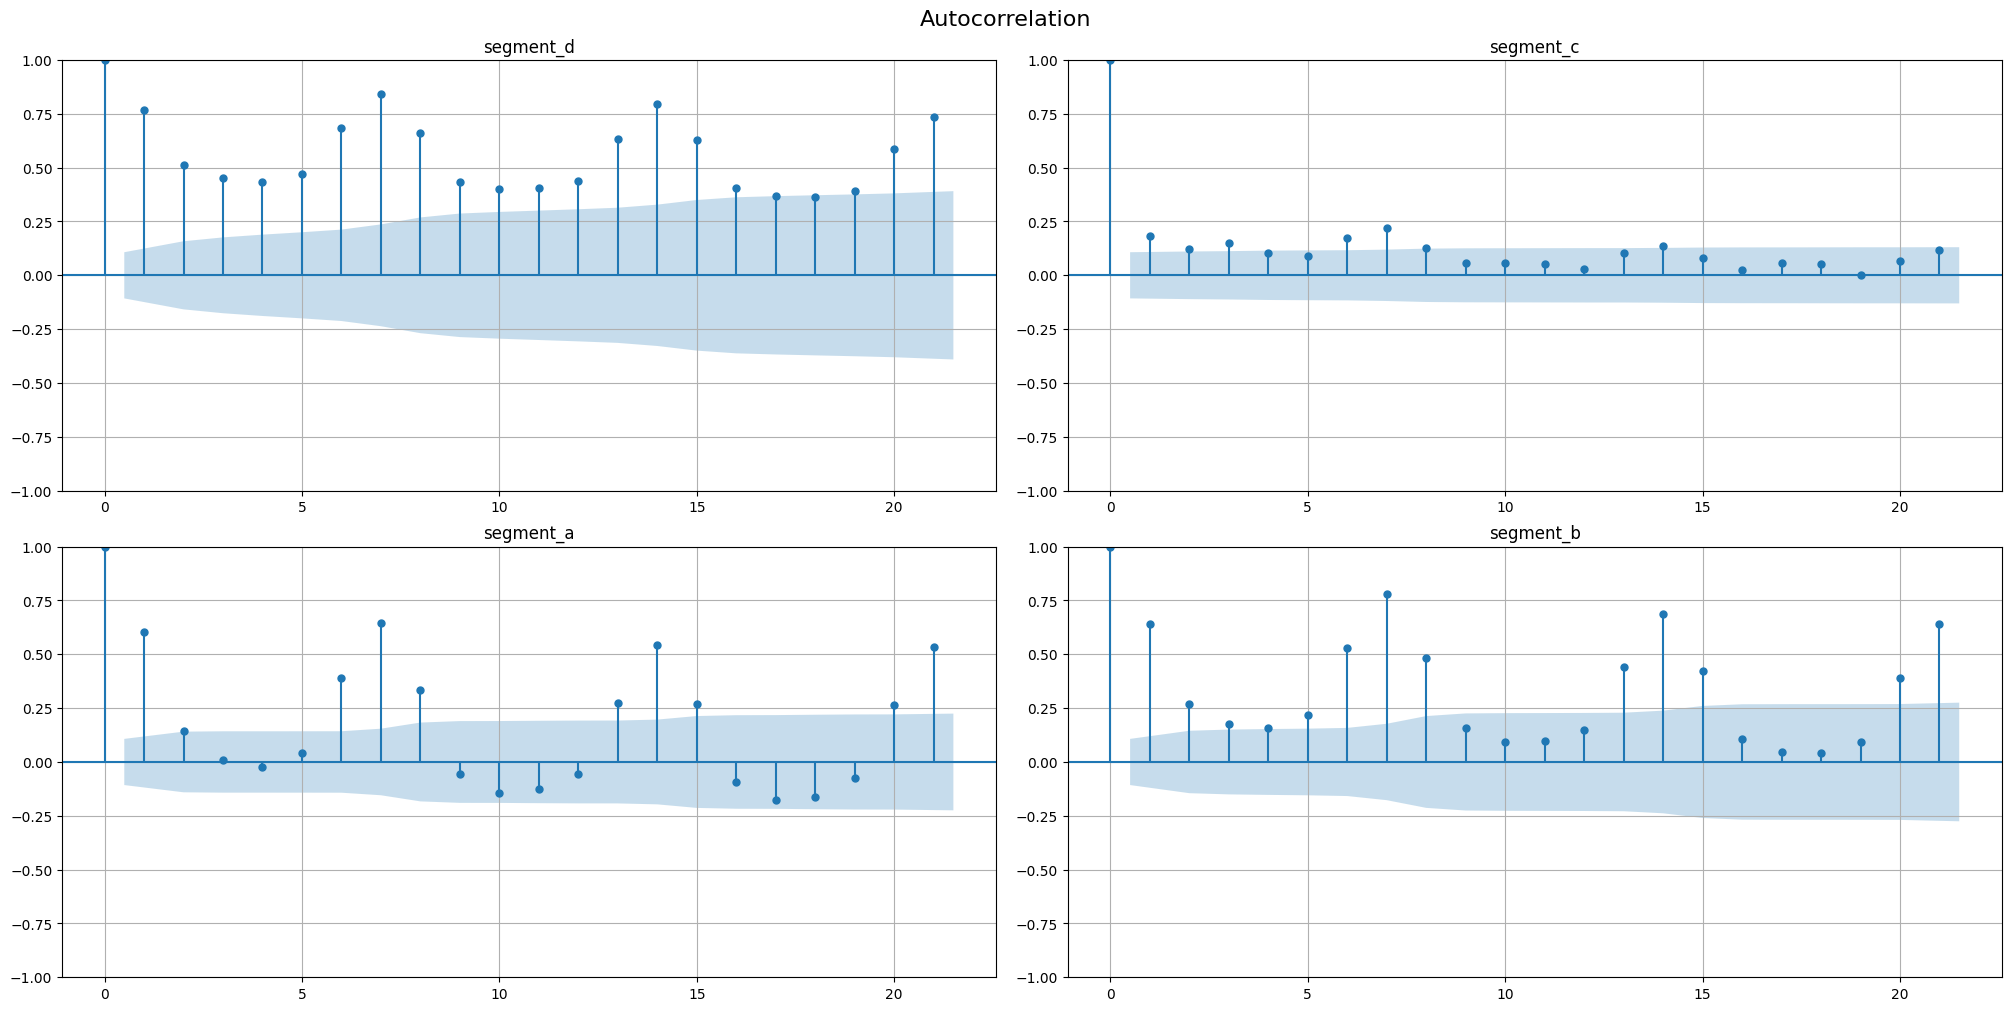

In [47]:
sample_acf_plot(ts, lags=21)

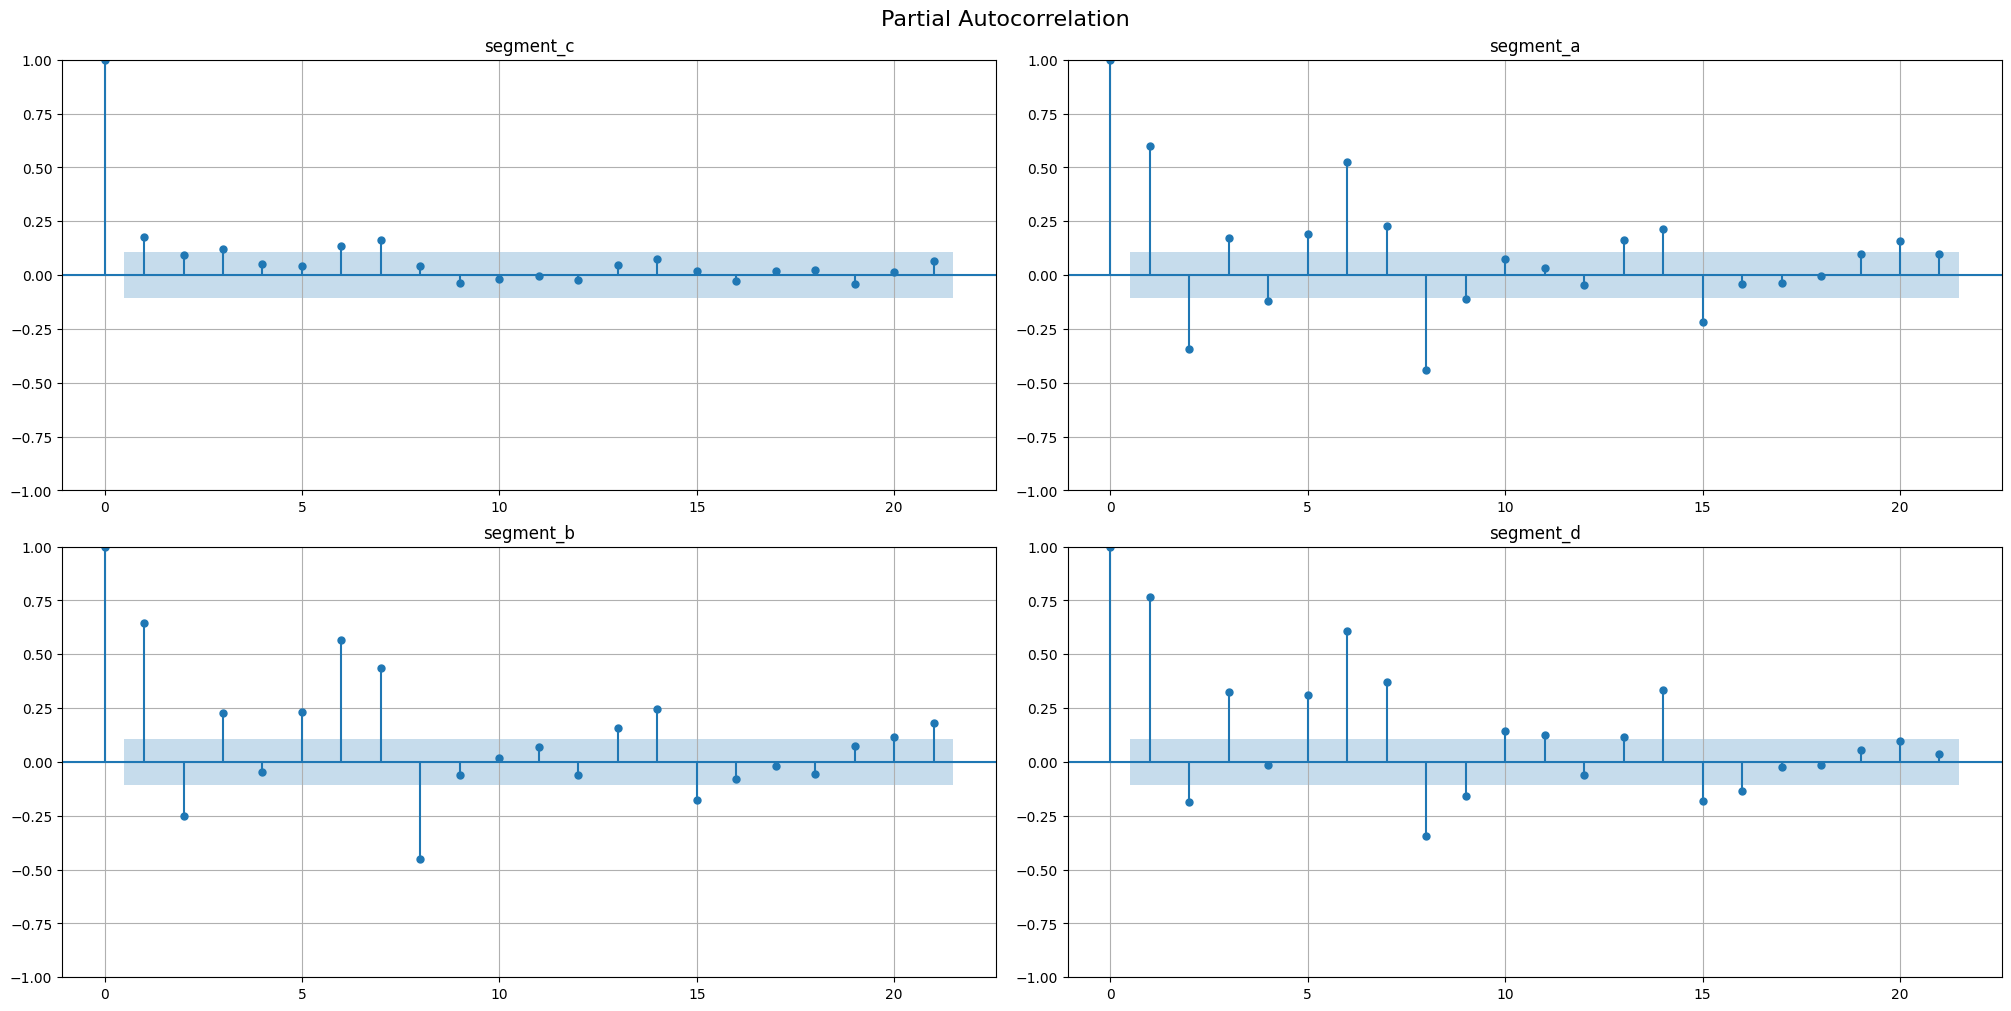

In [48]:
sample_pacf_plot(ts, lags=21)

## 3.2. Взаимнокорреляционная функция (CCF)

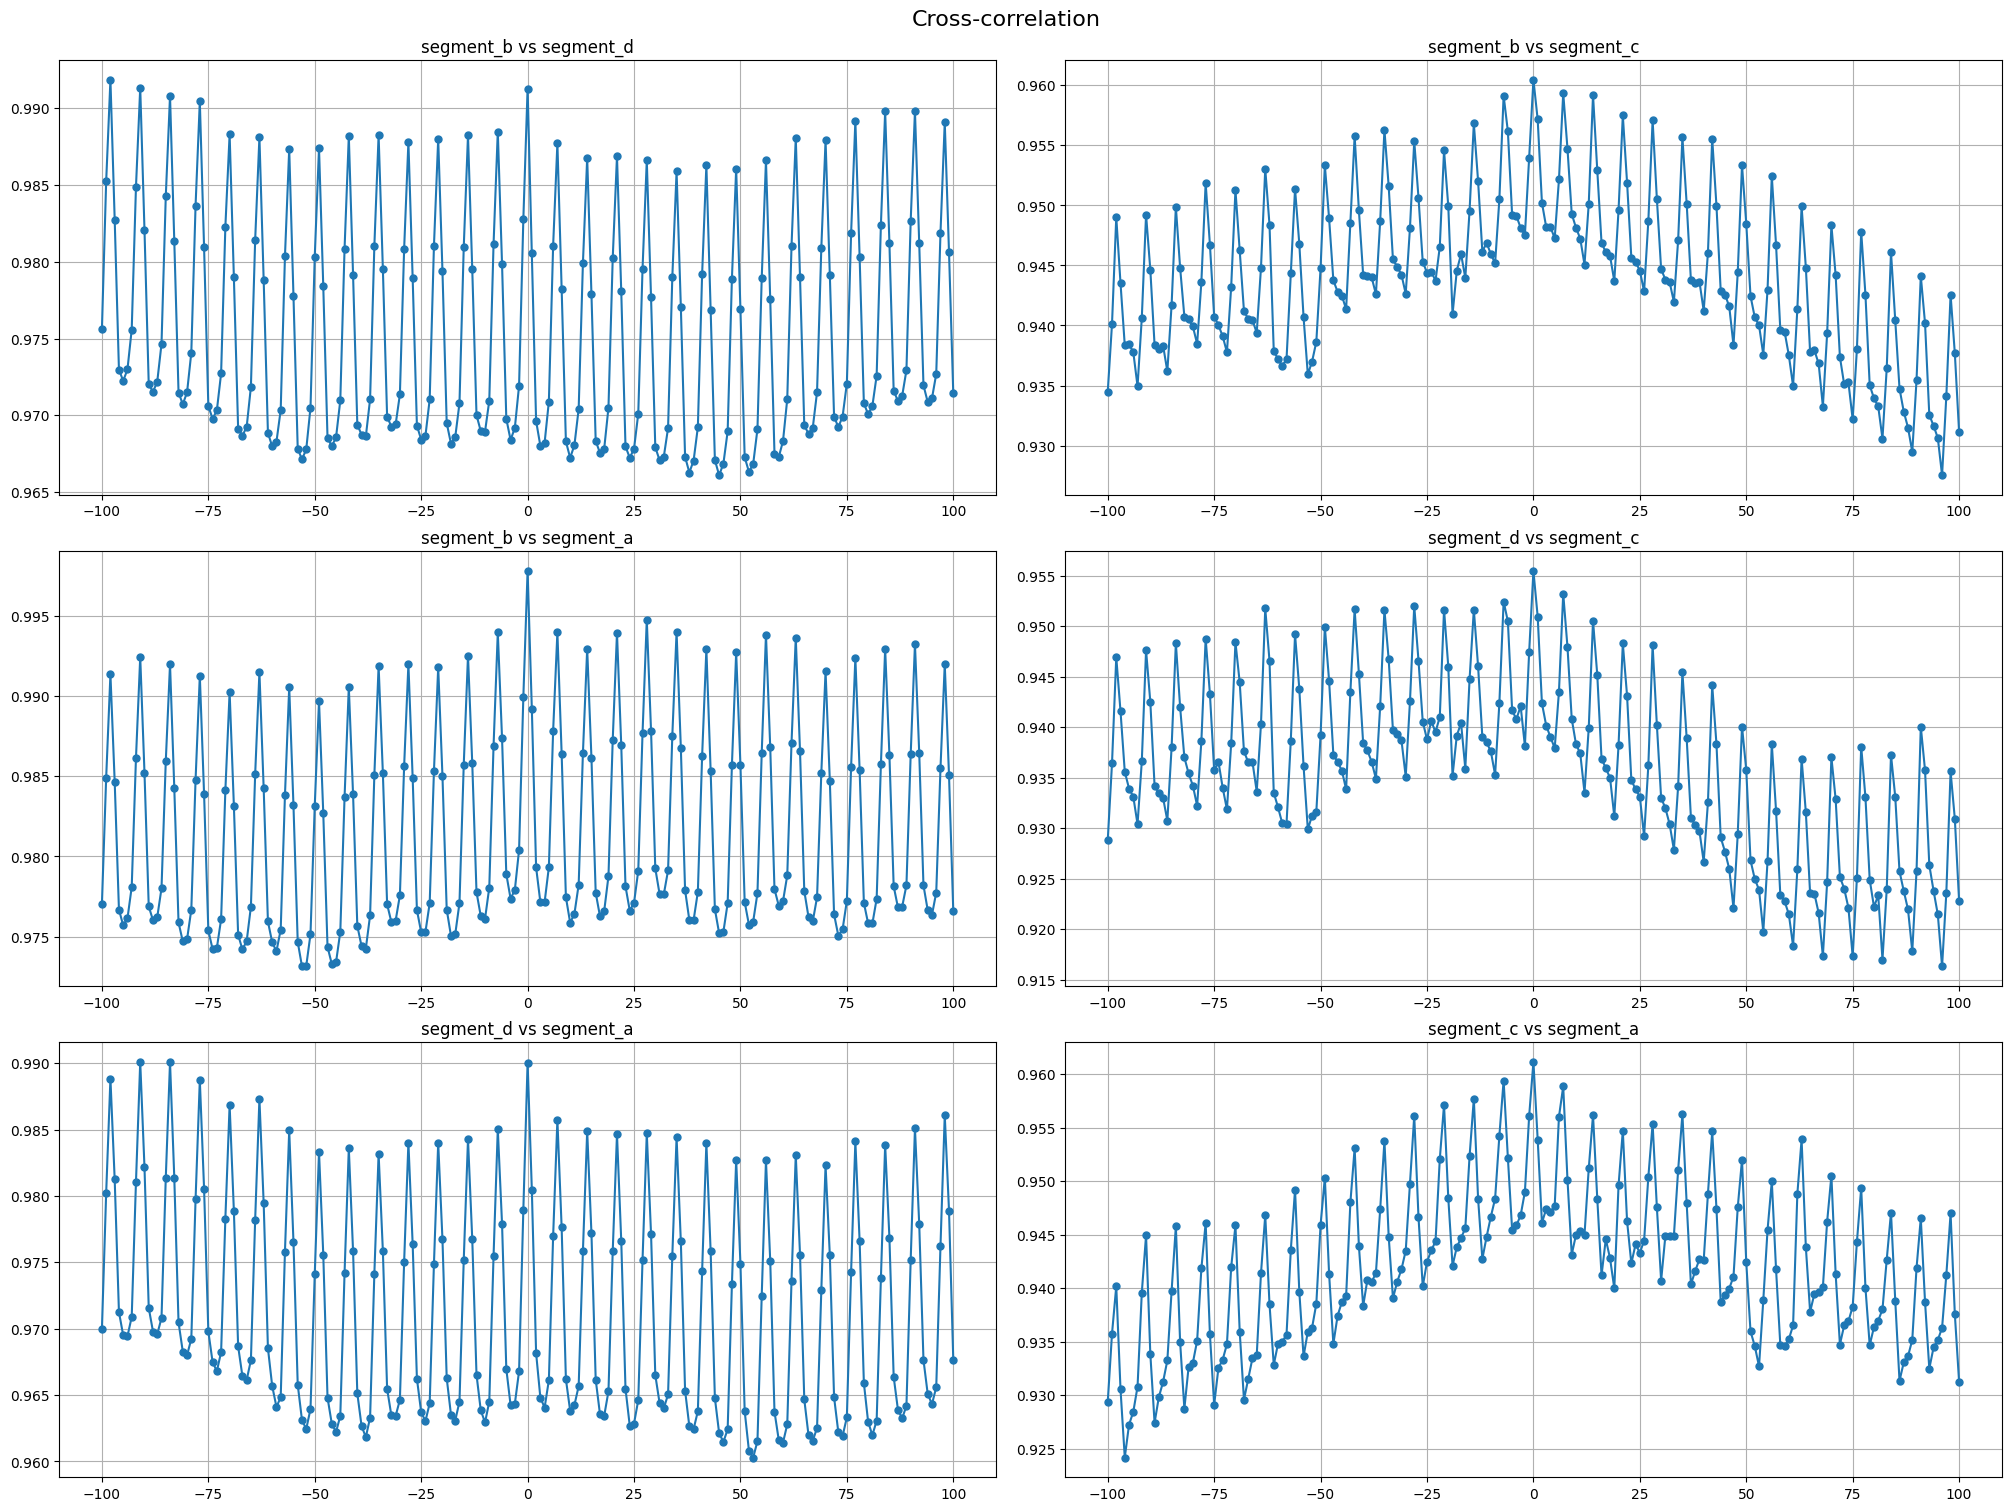

In [49]:
cross_corr_plot(ts, maxlags=100)

## 3.3. Корреляционная тепловая карта

Попарная корреляция между рядами - для выявления глобально коррелированных друг с другом рядов. Можно также добавить к сравнению ряды, составленные из лагов заданной величины.

In [50]:
lags = LagTransform(in_column="target", lags=[1, 7], out_column="lag")
ts.fit_transform([lags])

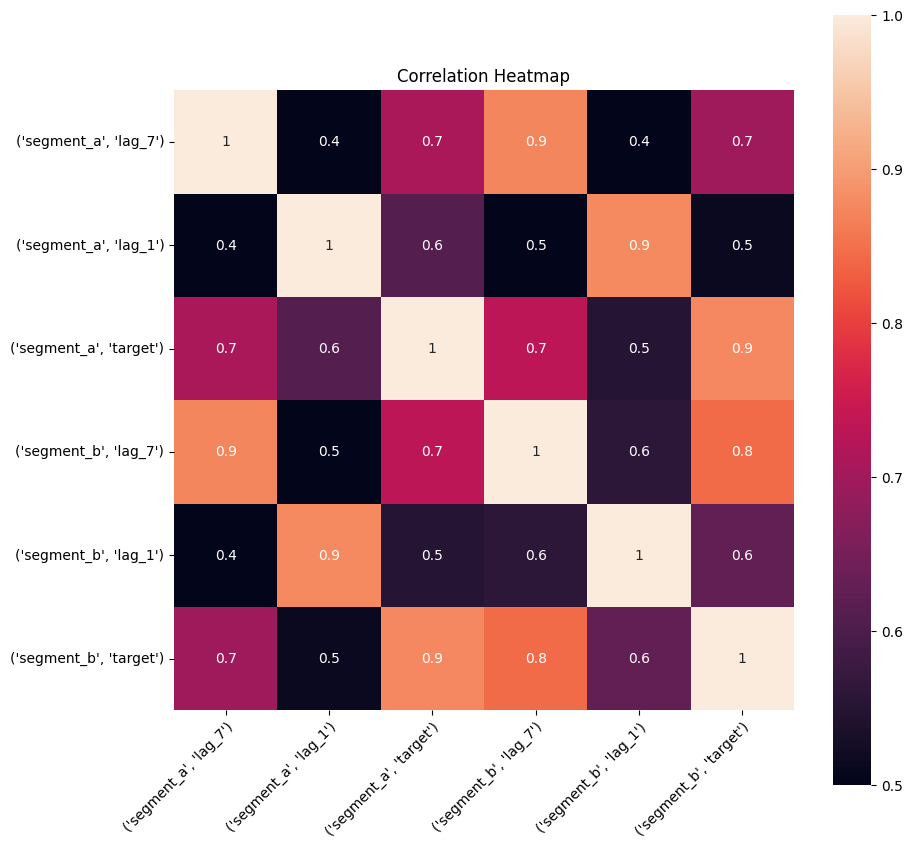

In [51]:
plot_correlation_matrix(
    ts, segments=["segment_a", "segment_b"], 
    method="spearman", 
    vmin=0.5, 
    vmax=1
)

## 3.4. Z-статистики
При помощи них мы можем, к примеру, построить стандартизированные оценки сдвига средних

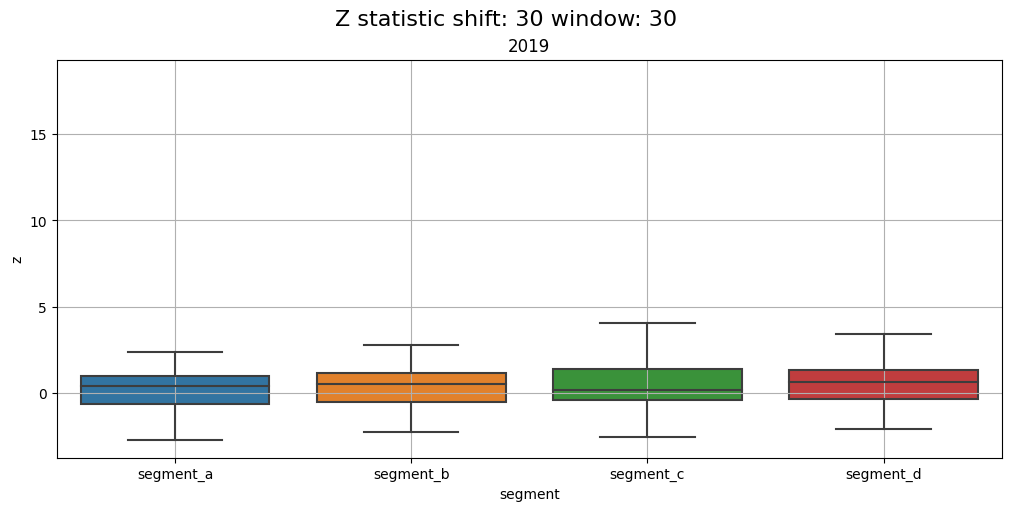

In [52]:
distribution_plot(ts, freq="1Y")

#### Перейдем к следующей компоненте EDA - настолько важной, что посвятим ей отдельный раздел:

# 4. Аутлаеры <a class="anchor" id="chapter4"></a>
[Назад к меню](#menu)

В ETNA мы можем детектировать, визуализировать и заменять (сглаживать) аутлаеры. Визуализировать мы можем, в том числе, задетектированные аутлаеры при помощи plot_anomalies

Аутлаеры могут быть как точечными, так и представлять из себя целые подпоследовательности. Мы сфокусируемся на первых, и для них предусмотрено 4 метода детекции:

*NB*: выбрать столбец для поиска аутлаеров мы можем при помощи параметра `in_column`.

## 4.1. Отклонение от медианных значений
Соответственно, необходимо задать ширину *окна* просмотра

In [53]:
#сбросим преобразования над ts
classic_df = toy_synthetic.copy(deep=True)
df = TSDataset.to_dataset(classic_df)
ts = TSDataset(df, freq="D")

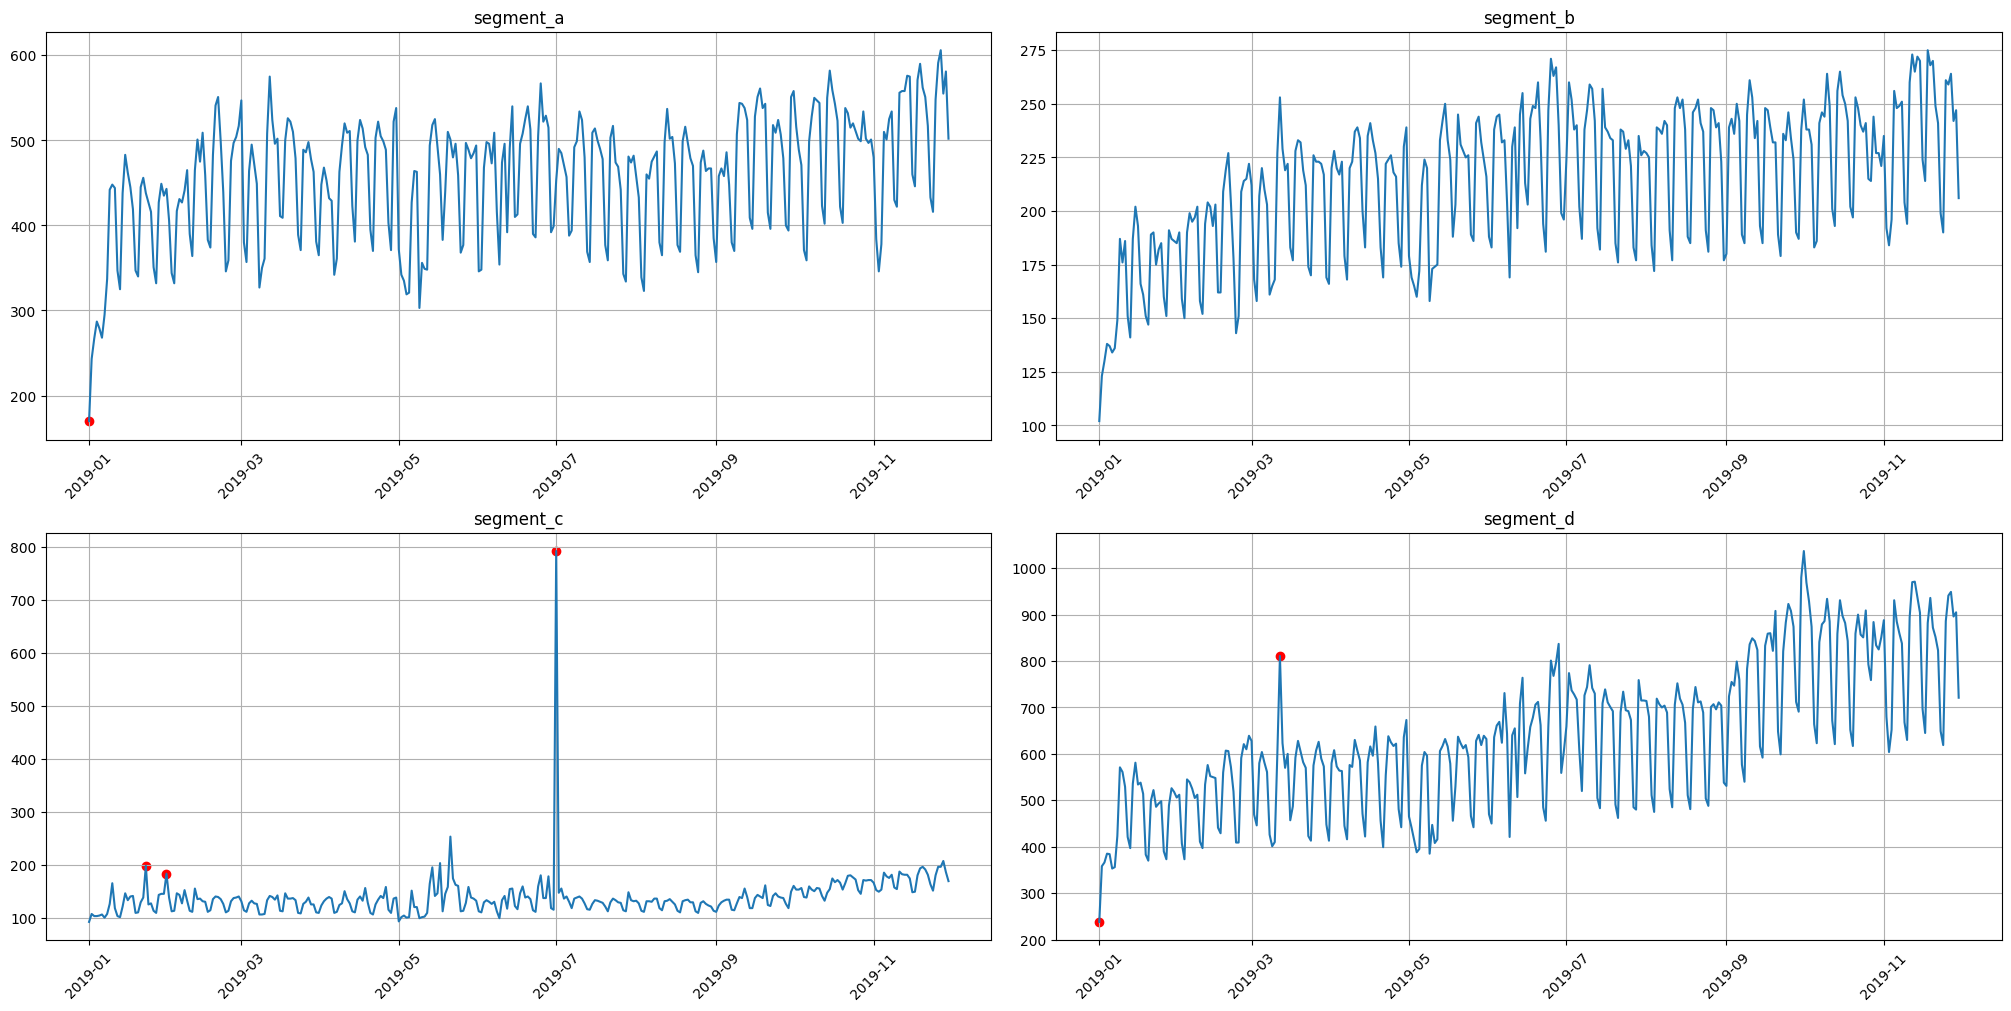

In [54]:
anomaly_dict = get_anomalies_median(ts, window_size=100)
plot_anomalies(ts, anomaly_dict)

## 4.2. Метод на основе плотности точек (density-based)
Метрический метод, требующий подбора гиперпараметров под искомые данные (как в примере внизу) - рассчитывать на дефолтные значения тут особо не приходится

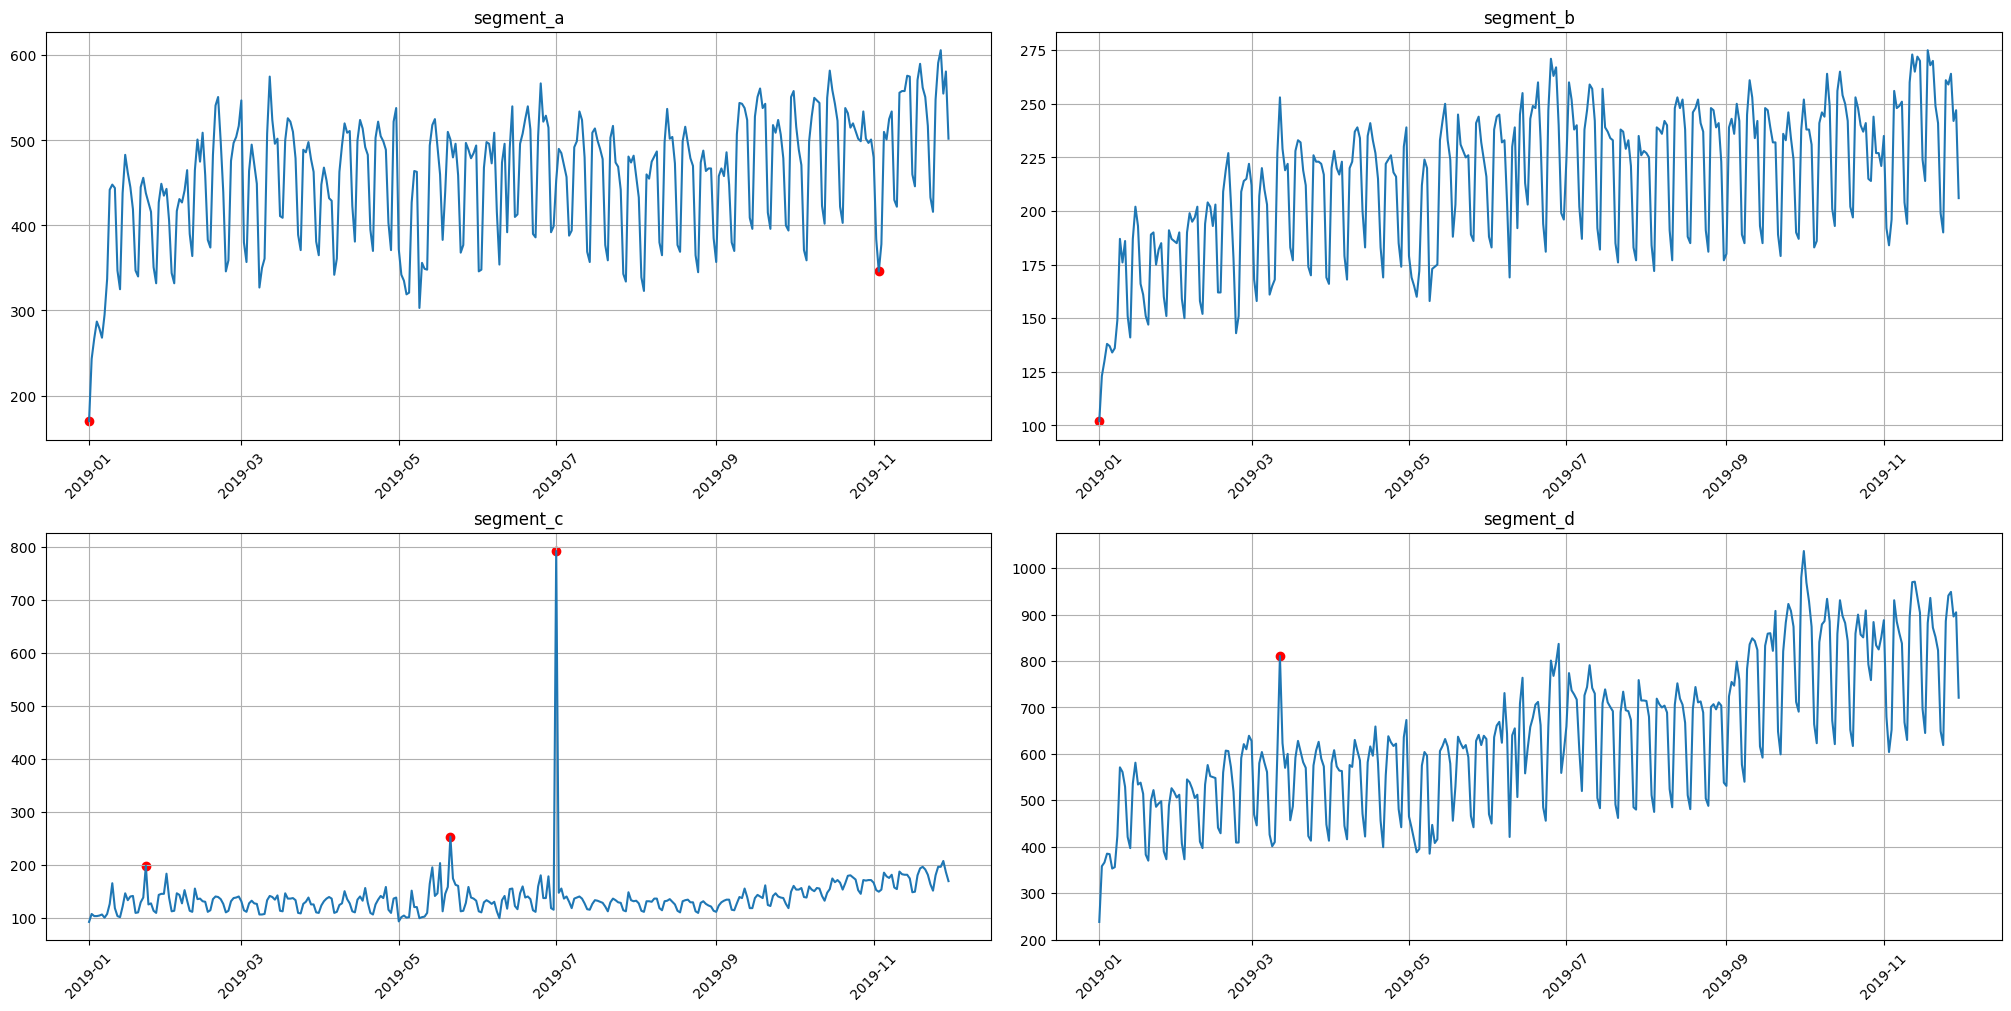

In [55]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

## 4.3. Метод на основе предсказаний модели
Model-based метод; аутлаерами считаются все точки выпадающие из интервала предсказания некоей модели (`model`). 

*NB*: в настоящий момент метод доступен только в связке с `ProphetModel` и `SARIMAXModel`.

12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing
12:00:26 - cmdstanpy - INFO - Chain [1] done processing


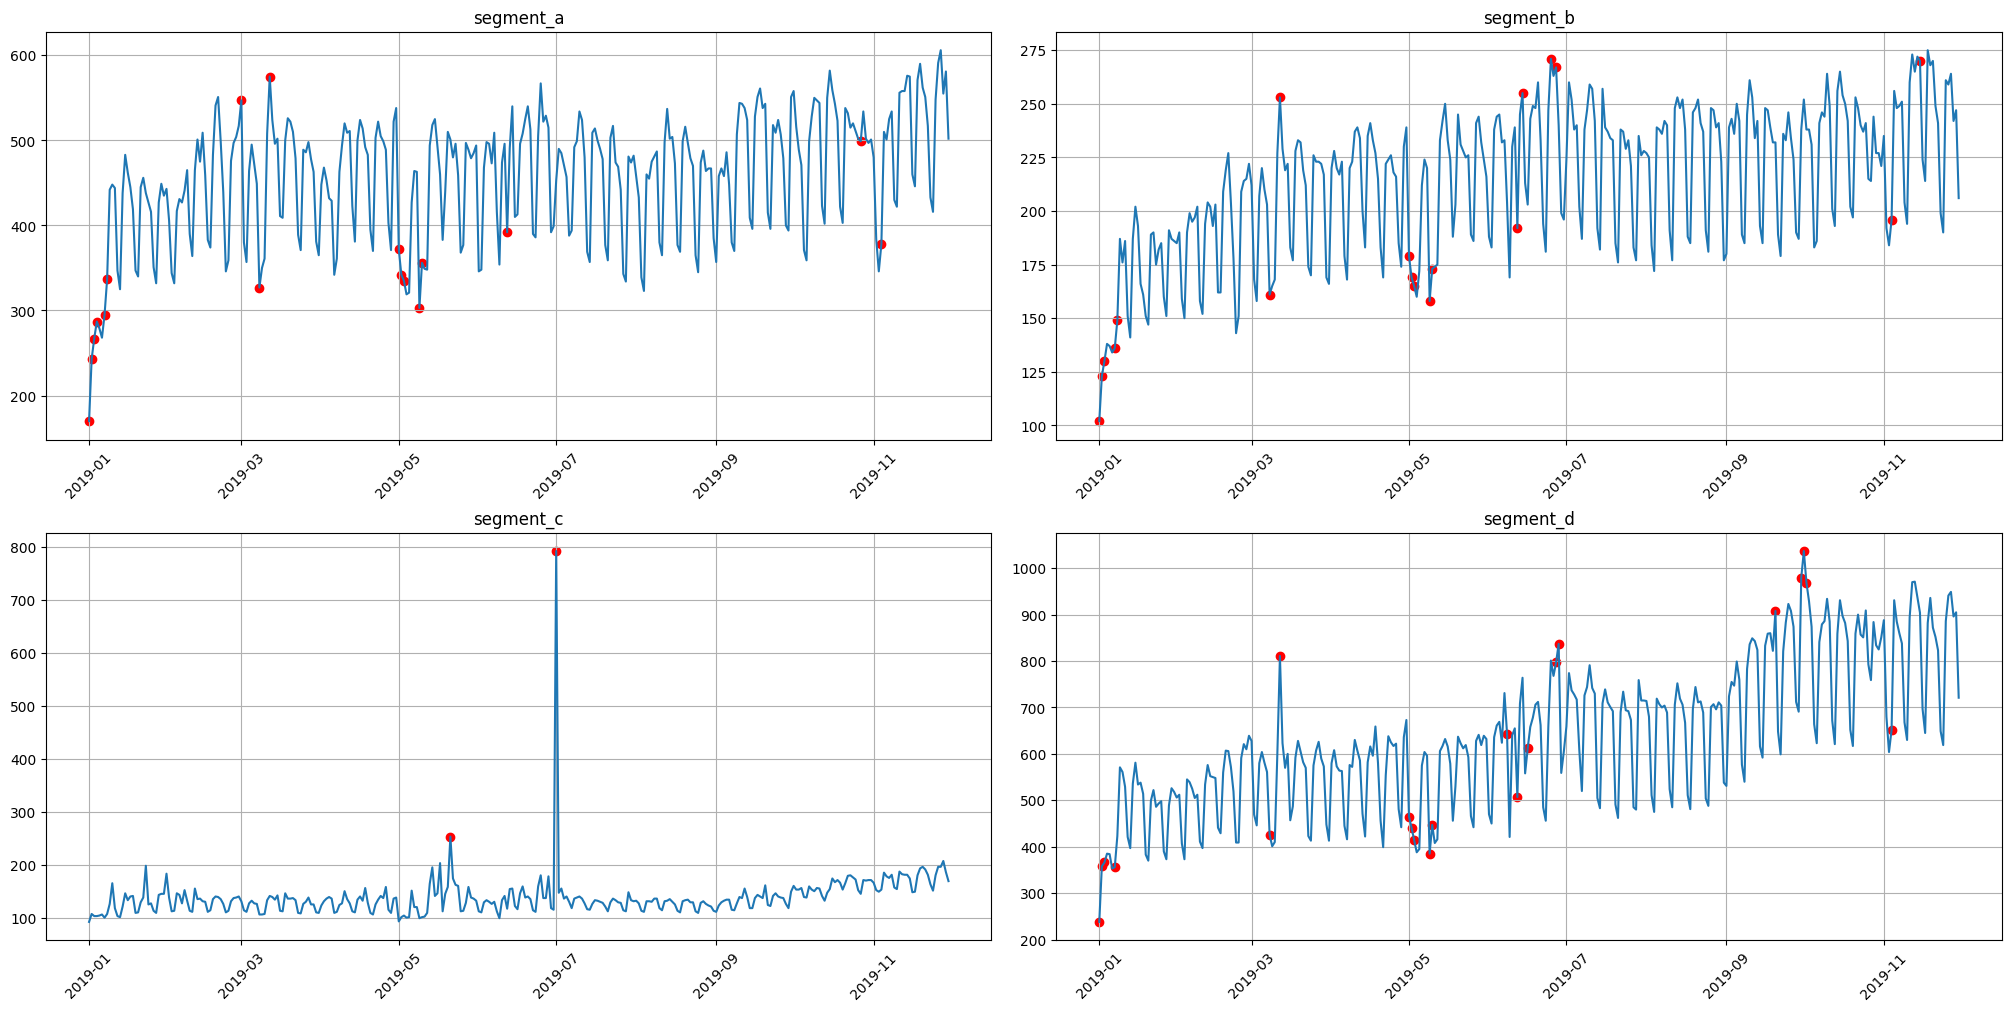

In [56]:
anomaly_dict = get_anomalies_prediction_interval(
    ts, 
    model=ProphetModel, 
    interval_width=0.95
)

plot_anomalies(ts, anomaly_dict)

## 4.4. Гистограммный метод
Детекция аутлаеров на основе гистограммной модели. Аутлаерами признаются все такие точки, при удалении которой в результате получается гистограмма с наименьшей ошибкой аппроксимации. 

*NB:* может работать небыстро

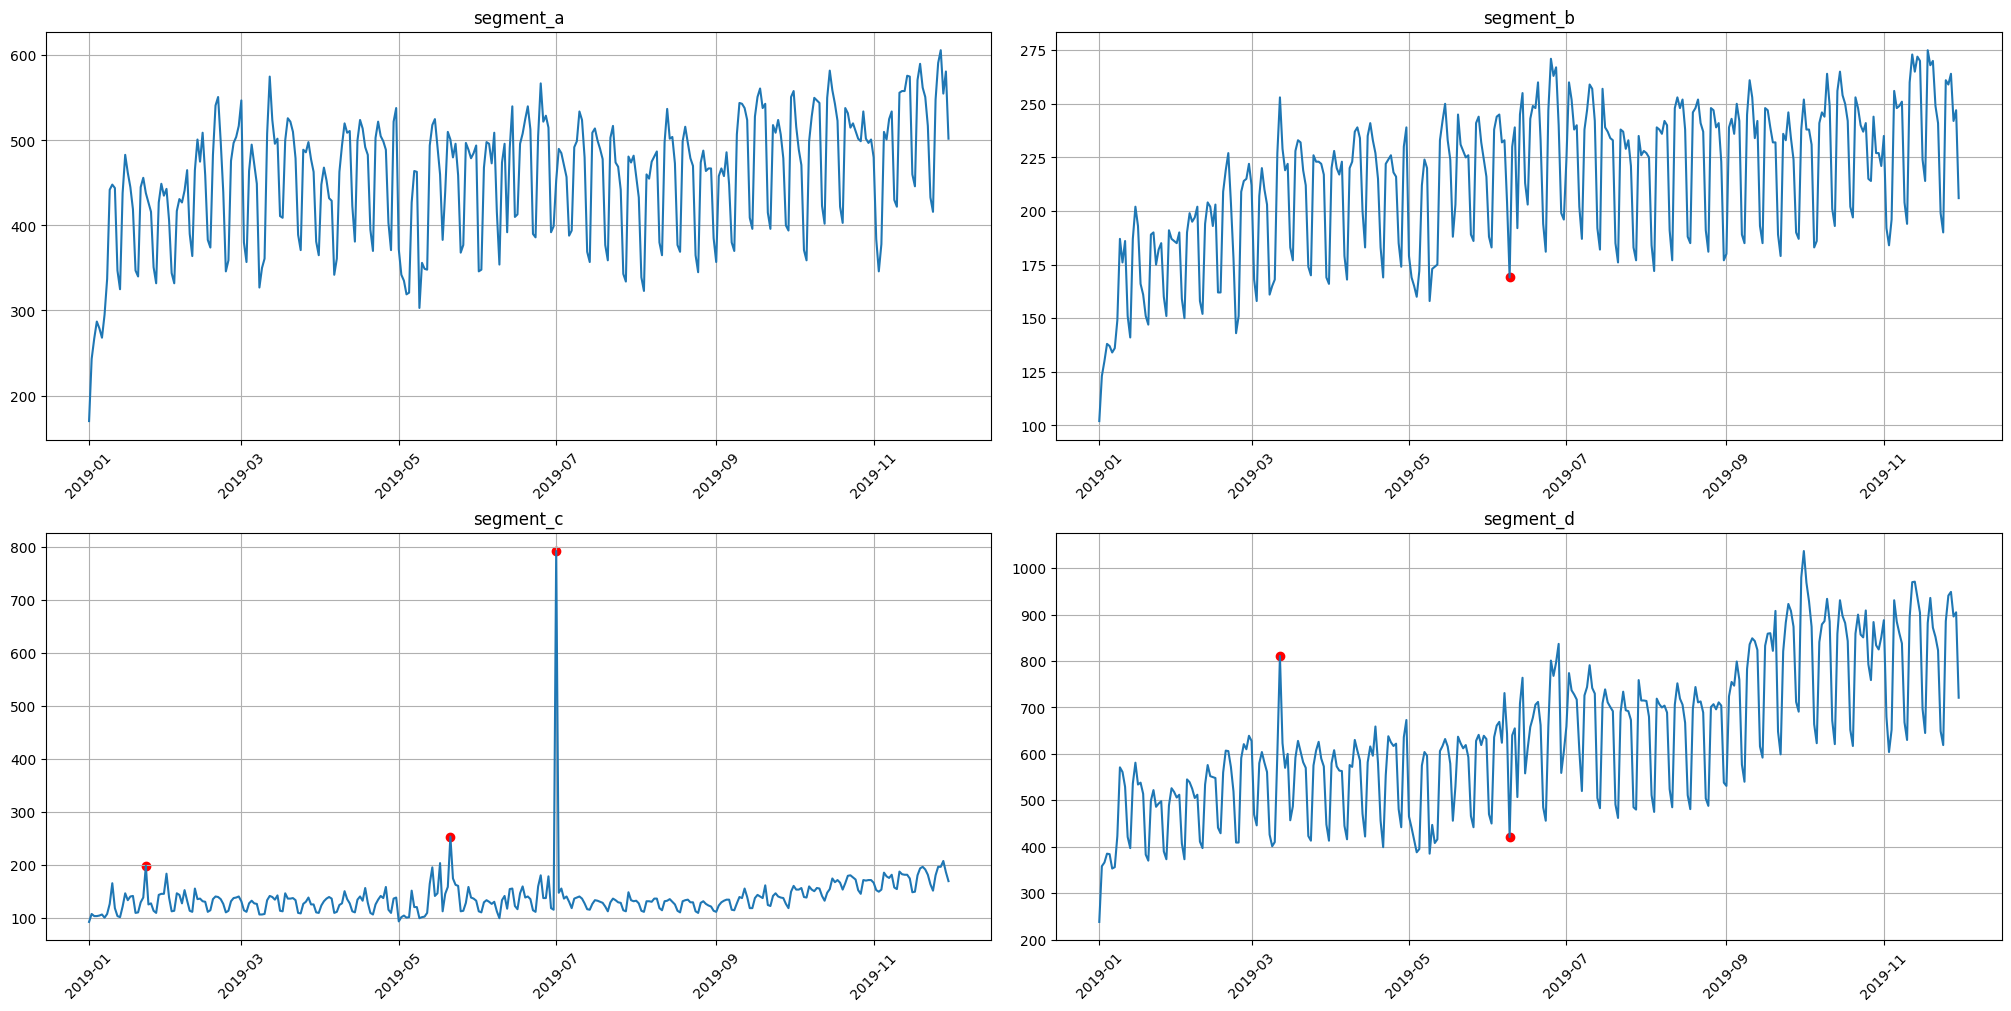

In [57]:
anomaly_dict = get_anomalies_hist(ts, bins_number=10)
plot_anomalies(ts, anomaly_dict)

## 4.5. Интерактивная визуализация
Качество работы аглоритмов детекции аутлаеров может существенным образом зависеть от значений гиперпараметров. Чтобы подобрать их наилучшим образом, можно воспользоваться интерактивной визуализацией

Нужно задать **segment**, **method** детекции аутлаеров и **parameters grid** в формате (min, max, step) для каждого параметра.

In [58]:
segment = "segment_c"
method = get_anomalies_median
params_bounds = {"window_size": (40, 70, 1), "alpha": (0.1, 4, 0.25)}

В случае проблем с отображением в юпитер-ноутбуке, можно попробовать запустить `!jupyter nbextension enable --py widgetsnbextension`

In [59]:
plot_anomalies_interactive(
    ts=ts, 
    segment=segment, 
    method=method, 
    params_bounds=params_bounds
)

interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', max=70, min=40, …

Можно предположить, что лучший набор гиперпараметров в нашем случае выглядит так:

In [60]:
best_params = {"window_size": 60, "alpha": 2.35}

## 4.6. Замена (сглаживание) аутлаеров
Аутлаеры можно не только детектировать, но и пытаться заменить на (предположительно) более адекватные значения. Давайте посмотрим как это работает.

Segment с аутлаерами:

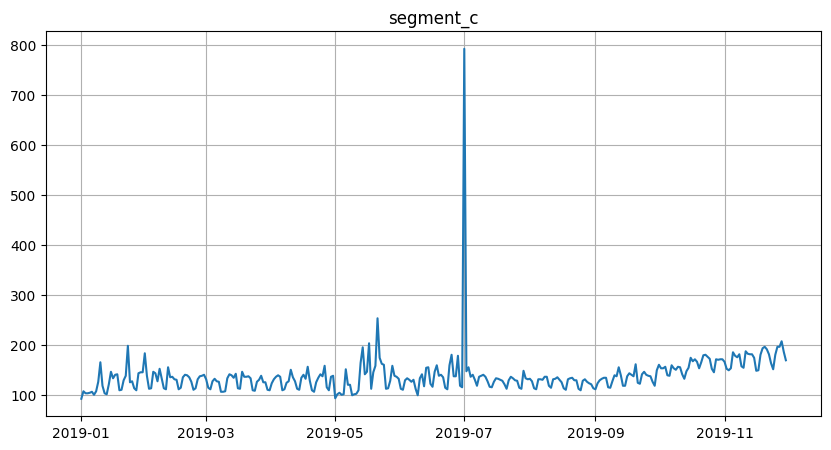

In [61]:
df = ts[:, segment, :]
ts = TSDataset(df, freq="D")
ts.plot()

Замена аутлаеров состоит из двух шагов:
1. Заменим задетектированные аутлаеры на NaNs при помощи экземпляра класса *OutliersTransform*
2. Заполним NaNs при помощи экземпляра класса *TimeSeriesImputerTransform*

Попробуем в качестве метода детекции использовать *median*, в качестве метода заполнения - стратегию *running_mean*:

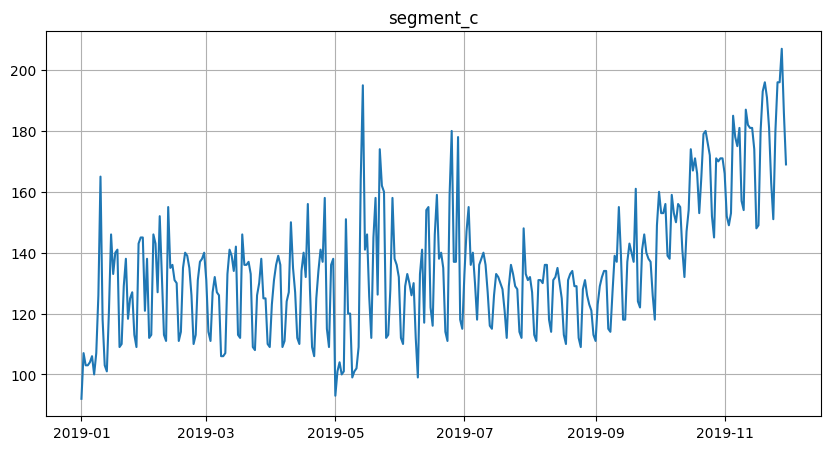

In [62]:
# Impute outliers with NaNs
outliers_remover = MedianOutliersTransform(in_column="target", **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", 
    strategy="running_mean", 
    window=30
)
ts.fit_transform([outliers_remover, outliers_imputer])
ts.plot()

Теперь мы можем обучить модель на очищенном датасете, что имеет потенциал улучшить ее качество. Выясним при помощи метрик, справедливо ли это предположение.

In [63]:
def get_metrics(forecast, test):
    """Compute the metrics on forecast"""
    metrics = {"MAE": MAE(), "MSE": MSE(), "SMAPE": SMAPE()}
    results = dict()
    for name, metric in metrics.items():
        results[name] = metric(y_true=test, y_pred=forecast)["segment_c"]
    return results

In [64]:
def test_transforms(transforms=[]):
    """Run the experiment on the list of transforms"""
    classic_df = pd.read_csv(f"{folder}/example_dataset.csv")
    df = TSDataset.to_dataset(classic_df[classic_df["segment"] == segment])
    ts = TSDataset(df, freq="D")
    train, test = ts.train_test_split(
        train_start="2019-05-20",
        train_end="2019-07-10",
        test_start="2019-07-11",
        test_end="2019-08-09",
    )

    model = Pipeline(
        model=MovingAverageModel(window=30), 
        transforms=transforms, 
        horizon=30
    )
    
    model.fit(train)
    forecast = model.forecast()
    metrics = get_metrics(forecast, test)
    return metrics

Результаты на исходном датасете:

In [65]:
test_transforms()

{'MAE': 40.08799715116714,
 'MSE': 1704.8554888537708,
 'SMAPE': 27.36913416466395}

Резлультаты на очищенном датасете (заменяем аутлаеры на трейне и предсказываем тест):

In [66]:
transforms = [outliers_remover, outliers_imputer]
test_transforms(transforms)

{'MAE': 11.606826505006092,
 'MSE': 196.5736131226554,
 'SMAPE': 8.94919204071121}

Как мы видим, в нашем случае произошло значительное улучшение метрики. Однако, без дисклеймера все же не обойтись - бывает, что точки, которые мы детектировали как аутлаеры, являются проявлением сложного неявного процесса, присутствующего во временном ряде. Очевидно, в таком случае стратегия их удаления и/или замены может улучшить качество модели.

# 5. Регрессоры и внешние данные <a class="anchor" id="chapter5"></a>
[Назад к меню](#menu)

## 5.1. Немного теории

### Что такое регрессоры?

Выше мы практически исключительно работали с тем, что называется **целевым временным рядом**.

> Целевой временной ряд - это временной ряд, который мы хотим предсказать.

Теперь представьте себе, что вы располагаете информацией о будущем, которая может помочь вам с предсказанием целевого ряда. Это может быть информация о празниках, погоде, регулярных событиях, маркетинговых кампаниях и тд. Будем называть их **регрессорами**.

> Регрессоры - временные ряды, которые мы не заинтереснованы прогнозировать, но которые, тем не менее, могут помочь в прогнозировании целевого временного ряда.

Для того, чтобы применить регрессоры в модели и улучшить предсказания, необходимо знать влияние регрессоров на целевой ряд в прошлом, а так же иметь информацию об их значениях в будущем.

### Что такое дополнительные данные?

Существует (и весьма обширный!) класс данных, которые мы не знаем заранее.
Тем не менее, их использование могло бы помочь нам в нашей задаче предсказания. Назовем такие данные **дополнительными данными**.

К примеру, если много пользователей купили новую модель телефона несколько недель назад, логично ожидать наплыв запросов в поддержку касательно этой модели.

Чтобы использовать дополнительные данные в модели нам необходимо сделать из них регрессоры. К примеру, при помощи экземпляров методов LagTransform или TrendTransform.

Использование **дополнительные данных** выходит за рамки семинара, в нем мы сфокусируемся исключительно на **регрессорах**.

## 5.2. Kaggle merch датасет

ETNA позволяет нам работать с регрессорами столь же удобным образом, как и с целевым рядом.

На этот раз займемся предсказанием целевого ряда из соревнования [Tabular Playground Series - Jan 2022](https://www.kaggle.com/c/tabular-playground-series-jan-2022/overview).
Данные содержат дневные продажи мерча – кружки, кепки и стикеры – в двух воображаемых торговых сетях6 оперирующих в трех скандинавских странах. В качестве внешних данных будем использовать датасет
[Finland, Norway, and Sweden Weather Data 2015-2019](https://www.kaggle.com/adamwurdits/finland-norway-and-sweden-weather-data-20152019?select=nordics_weather.csv), в котором содержатся дневные данные касательно осадков, глубины снега и температуры воздуха в рассматриваемых странах.

In [67]:
target_df = kaggle_merch
regressor_df = nordics_weather

Как всегда, вначале сконвертируем данные в форматы, с которыми работает ETNA. Один и тот же код позволит сделать это как для целевых, так и для внешних данных.

In [68]:
target_df = TSDataset.to_dataset(target_df)
target_df.tail()

segment    Finland_KaggleMart_Kaggle Hat Finland_KaggleMart_Kaggle Mug  \
feature                           target                        target   
timestamp                                                                
2018-12-27                           573                           414   
2018-12-28                           841                           499   
2018-12-29                          1107                           774   
2018-12-30                          1113                           757   
2018-12-31                           822                           469   

segment    Finland_KaggleMart_Kaggle Sticker Finland_KaggleRama_Kaggle Hat  \
feature                               target                        target   
timestamp                                                                    
2018-12-27                               177                          1068   
2018-12-28                               223                          1398   
2018-12-29                               296                          1895   
2018-12-30                               326                          1878   
2018-12-31                               238                          1231   

segment    Finland_KaggleRama_Kaggle Mug Finland_KaggleRama_Kaggle Sticker  \
feature                           target                            target   
timestamp                                                                    
2018-12-27                           652                               308   
2018-12-28                           895                               431   
2018-12-29                          1398                               559   
2018-12-30                          1241                               554   
2018-12-31                           831                               360   

segment    Norway_KaggleMart_Kaggle Hat Norway_KaggleMart_Kaggle Mug  \
feature                          target                       target   
timestamp                                                              
2018-12-27                          898                          568   
2018-12-28                         1162                          731   
2018-12-29                         1650                         1113   
2018-12-30                         1809                         1052   
2018-12-31                         1124                          728   

segment    Norway_KaggleMart_Kaggle Sticker Norway_KaggleRama_Kaggle Hat  \
feature                              target                       target   
timestamp                                                                  
2018-12-27                              270                         1604   
2018-12-28                              361                         2178   
2018-12-29                              518                         2884   
2018-12-30                              500                         2851   
2018-12-31                              351                         2128   

segment    Norway_KaggleRama_Kaggle Mug Norway_KaggleRama_Kaggle Sticker  \
feature                          target                           target   
timestamp                                                                  
2018-12-27                         1108                              436   
2018-12-28                         1333                              662   
2018-12-29                         1816                              874   
2018-12-30                         1935                              833   
2018-12-31                         1383                              561   

segment    Sweden_KaggleMart_Kaggle Hat Sweden_KaggleMart_Kaggle Mug  \
feature                          target                       target   
timestamp                                                              
2018-12-27                          672                          420   
2018-12-28                          874                          555   
20

Таргет заканчивается в 2018, в то время как внешние данные - в 2019,
таким образом мы располагаем некоторой внешней информацией на год вперед.
Соответственно, наши внешние данные содержат исключительно готовые регрессоры.

In [69]:
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df.tail()

segment    Finland_KaggleMart_Kaggle Hat                                  \
feature                    precipitation  snow_depth      tavg      tmax   
timestamp                                                                  
2019-12-27                      0.028249  109.550000 -8.529630 -3.161039   
2019-12-28                      0.789266  116.421053 -9.107407 -4.703947   
2019-12-29                      4.976966  117.117647 -0.418519  1.264052   
2019-12-30                      1.229775  160.500000  2.292593  3.344156   
2019-12-31                      0.225281  124.647059 -2.859259  1.580519   

segment               Finland_KaggleMart_Kaggle Mug                        \
feature          tmin                 precipitation  snow_depth      tavg   
timestamp                                                                   
2019-12-27 -10.895425                      0.028249  109.550000 -8.529630   
2019-12-28 -15.288889                      0.789266  116.421053 -9.107407   
2019-12-29  -7.722078                      4.976966  117.117647 -0.418519   
2019-12-30  -0.202632                      1.229775  160.500000  2.292593   
2019-12-31  -6.921569                      0.225281  124.647059 -2.859259   

segment                          ... Sweden_KaggleRama_Kaggle Mug              \
feature         tmax       tmin  ...                precipitation  snow_depth   
timestamp                        ...                                            
2019-12-27 -3.161039 -10.895425  ...                     0.105079  141.220930   
2019-12-28 -4.703947 -15.288889  ...                     1.117688  142.955224   
2019-12-29  1.264052  -7.722078  ...                     1.758669  136.725146   
2019-12-30  3.344156  -0.202632  ...                     0.561996  120.740741   
2019-12-31  1.580519  -6.921569  ...                     0.848161  131.583333   

segment                                   Sweden_KaggleRama_Kaggle Sticker  \
feature         tavg      tmax       tmin                    precipitation   
timestamp                                                                    
2019-12-27 -4.277778 -2.391204  -8.993458                         0.105079   
2019-12-28 -3.866667 -3.006542 -11.593056                         1.117688   
2019-12-29  1.755556  3.692056  -4.516204                         1.758669   
2019-12-30  4.900000  6.135648   1.859070                         0.561996   
2019-12-31  1.722222  4.376606  -2.290278                         0.848161   

segment                                                
feature     snow_depth      tavg      tmax       tmin  
timestamp                                              
2019-12-27  141.220930 -4.277778 -2.391204  -8.993458  
2019-12-28  142.955224 -3.866667 -3.006542 -11.593056  
2019-12-29  136.725146  1.755556  3.692056  -4.516204  
2019-12-30  120.740741  4.900000  6.135648   1.859070  
2019-12-31  131.583333  1.722222  4.376606  -2.290278  

[5 rows x 90 columns]

Нам необходимо создать TSDataset, который будет содержать как целевой ряд, так и внешние данные. По сигнатуре класса TSDataset мы должны передать целевой ряд в качестве аргумента df, а внешние данные в качестве аргумента df_exog. Мы используем параметр `known_future` с тем, чтобы разделить столбцы df_exog на те, что содержат **регрессоры** (в данном случае все), и те, что содержат **дополнительные данные**.

In [70]:
ts = TSDataset(df=target_df, freq="D", df_exog=regressor_df, known_future="all")
ts.head()

segment    Finland_KaggleMart_Kaggle Hat                                \
feature                    precipitation  snow_depth target       tavg   
timestamp                                                                
2015-01-01                      1.714141  284.545455  520.0   1.428571   
2015-01-02                     10.016667  195.000000  493.0   0.553571   
2015-01-03                      3.956061  284.294118  535.0  -1.739286   
2015-01-04                      0.246193  260.772727  544.0  -7.035714   
2015-01-05                      0.036364  236.900000  378.0 -17.164286   

segment                         Finland_KaggleMart_Kaggle Mug              \
feature         tmax       tmin                 precipitation  snow_depth   
timestamp                                                                   
2015-01-01  2.912739  -1.015287                      1.714141  284.545455   
2015-01-02  2.358599  -0.998718                     10.016667  195.000000   
2015-01-03  0.820382  -3.463871                      3.956061  284.294118   
2015-01-04 -3.110828  -9.502581                      0.246193  260.772727   
2015-01-05 -8.727564 -19.004487                      0.036364  236.900000   

segment                       ... Sweden_KaggleRama_Kaggle Mug        \
feature    target       tavg  ...                       target  tavg   
timestamp                     ...                                      
2015-01-01  329.0   1.428571  ...                        706.0  3.47   
2015-01-02  318.0   0.553571  ...                        653.0  3.80   
2015-01-03  360.0  -1.739286  ...                        734.0  1.61   
2015-01-04  332.0  -7.035714  ...                        657.0 -1.35   
2015-01-05  243.0 -17.164286  ...                        512.0 -4.27   

segment                        Sweden_KaggleRama_Kaggle Sticker             \
feature         tmax      tmin                    precipitation snow_depth   
timestamp                                                                    
2015-01-01  5.415354  0.221569                         3.642278  84.924623   
2015-01-02  5.097244  0.294882                         2.414665  67.043702   
2015-01-03  2.140392 -1.776680                         0.212793  79.945946   
2015-01-04 -0.648425 -5.173123                         0.226833  78.997290   
2015-01-05 -3.027451 -9.544488                         0.515601  79.736148   

segment                                      
feature    target  tavg      tmax      tmin  
timestamp                                    
2015-01-01  324.0  3.47  5.415354  0.221569  
2015-01-02  293.0  3.80  5.097244  0.294882  
2015-01-03  319.0  1.61  2.140392 -1.776680  
2015-01-04  300.0 -1.35 -0.648425 -5.173123  
2015-01-05  227.0 -4.27 -3.027451 -9.544488  

[5 rows x 108 columns]

### Выборочные отрисовки вспомогательных датасетов:

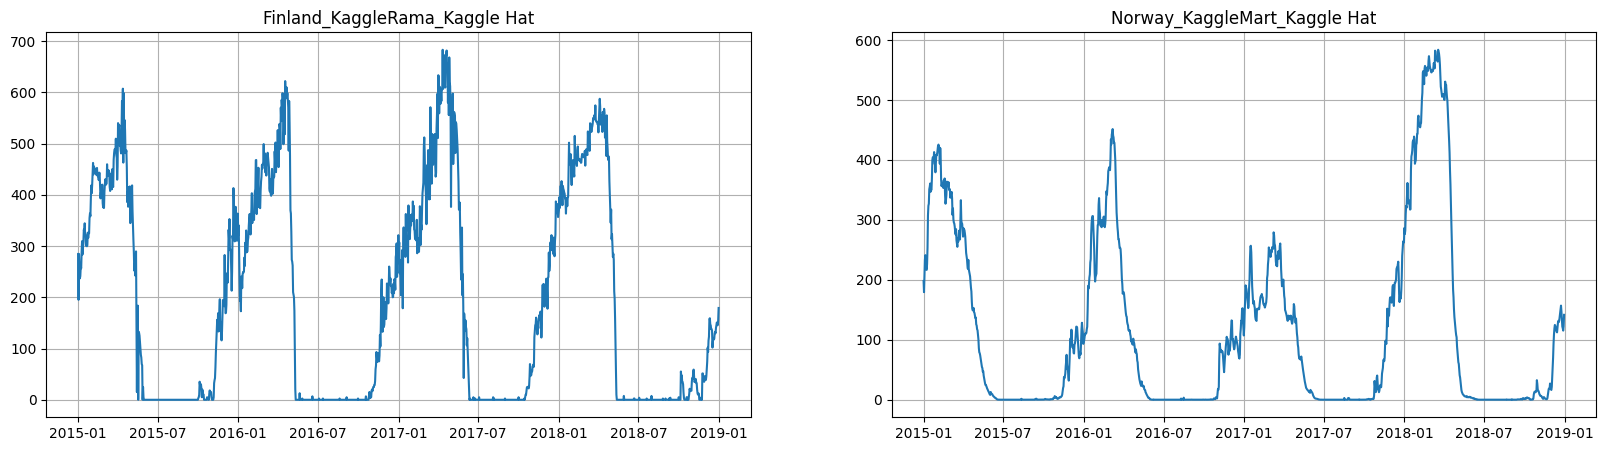

In [71]:
ts.plot(column="snow_depth", n_segments=2)

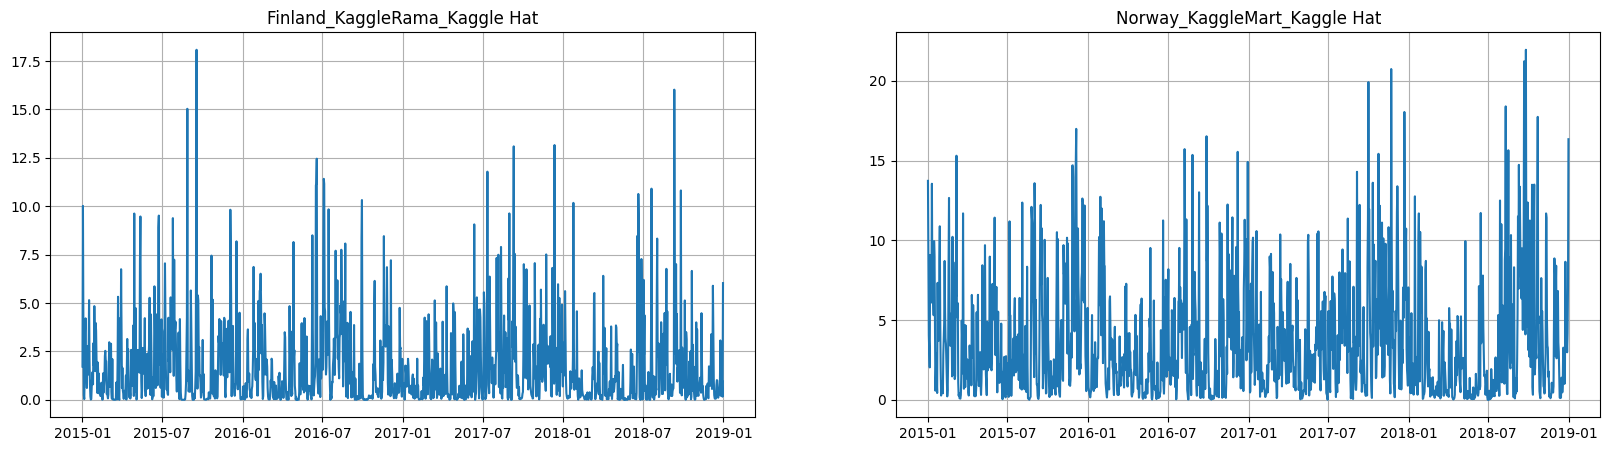

In [72]:
ts.plot(column="precipitation", n_segments=2)

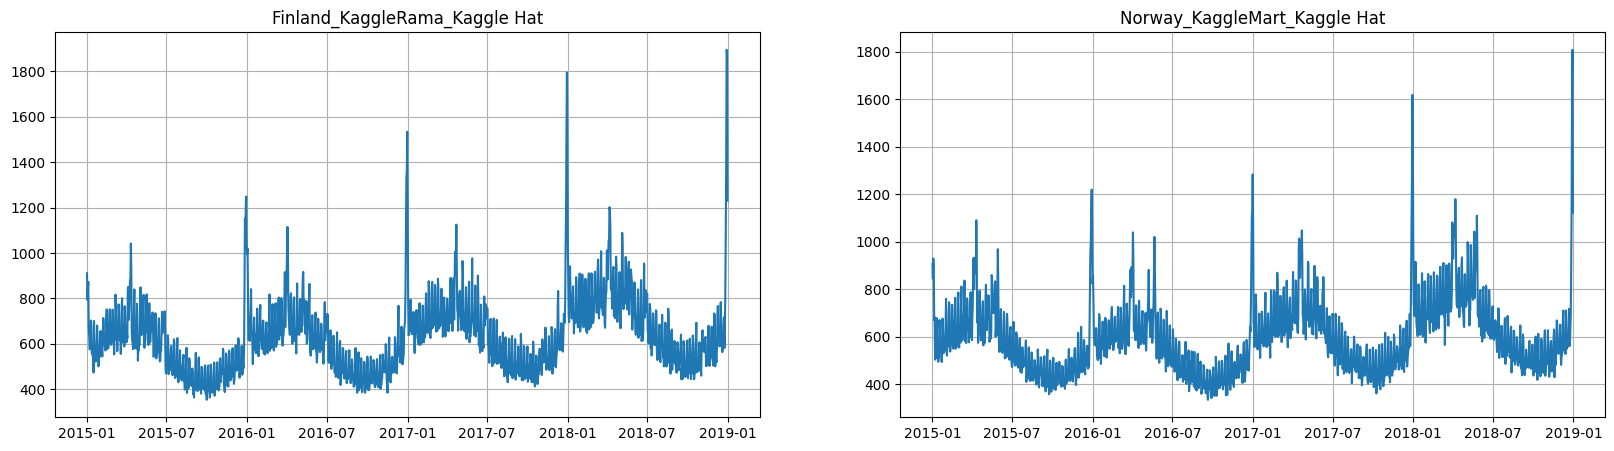

In [73]:
ts.plot(column="target", n_segments=2)

## 5.3. Собственно, предсказания с регрессорами

Будем использовать LinearPerSegmentModel (несложная модель, позволяющая работать с регрессорами).

> NB: некоторые модели не поддерживают работу с регрессорами, и выдадут соответствующее предупреждение.

Наша задача состоит в том, чтобы предсказать продажи мерча на год вперед при помощи регрессоров, дающих информацию о погоде.

In [74]:
HORIZON = 365
model = LinearPerSegmentModel()

ETNA позволяет задать конфигурации преобразований (transforms) для работы с внешними данными точно таким же образом, как и для работы с целевым рядом.

In [75]:
transforms = [
    LagTransform(
        in_column="target",
        lags=list(range(HORIZON, HORIZON + 28)),
        out_column="target_lag",
    ),
    LagTransform(in_column="tavg", lags=list(range(1, 3)), out_column="tavg_lag"),
    MeanTransform(in_column="tavg", window=7, out_column="tavg_mean"),
    MeanTransform(
        in_column="target_lag_365",
        out_column="target_mean",
        window=104,
        seasonality=7,
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        special_days_in_week=[4],
        out_column="date_flag",
    ),
    HolidayTransform(iso_code="SWE", out_column="SWE_holidays"),
    HolidayTransform(iso_code="NOR", out_column="NOR_holidays"),
    HolidayTransform(iso_code="FIN", out_column="FIN_holidays"),
    LagTransform(
        in_column="SWE_holidays",
        lags=list(range(2, 6)),
        out_column="SWE_holidays_lag",
    ),
    LagTransform(
        in_column="NOR_holidays",
        lags=list(range(2, 6)),
        out_column="NOR_holidays_lag",
    ),
    LagTransform(
        in_column="FIN_holidays",
        lags=list(range(2, 6)),
        out_column="FIN_holidays_lag",
    ),
    FilterFeaturesTransform(exclude=["precipitation", "snow_depth", "tmin", "tmax"]),
]

Дальнейшие шаги идентичны пайплайну работы исключительно с целевым рядом

In [76]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [77]:
metrics, forecasts, _ = pipeline.backtest(
    ts, 
    metrics=[SMAPE()], 
    aggregate_metrics=True, 
    n_folds=2
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s finished


In [78]:
metrics

segment      SMAPE
0       Finland_KaggleMart_Kaggle Hat   6.809976
1       Finland_KaggleMart_Kaggle Mug   7.897876
2   Finland_KaggleMart_Kaggle Sticker   7.566816
3       Finland_KaggleRama_Kaggle Hat   6.714908
4       Finland_KaggleRama_Kaggle Mug   7.443409
5   Finland_KaggleRama_Kaggle Sticker   7.540571
6        Norway_KaggleMart_Kaggle Hat   9.335215
7        Norway_KaggleMart_Kaggle Mug  11.929340
8    Norway_KaggleMart_Kaggle Sticker  11.455042
9        Norway_KaggleRama_Kaggle Hat   8.976252
10       Norway_KaggleRama_Kaggle Mug  11.691445
11   Norway_KaggleRama_Kaggle Sticker  11.594758
12       Sweden_KaggleMart_Kaggle Hat   6.837174
13       Sweden_KaggleMart_Kaggle Mug   7.319936
14   Sweden_KaggleMart_Kaggle Sticker   6.973164
15       Sweden_KaggleRama_Kaggle Hat   6.366672
16       Sweden_KaggleRama_Kaggle Mug   6.994042
17   Sweden_KaggleRama_Kaggle Sticker   7.081337

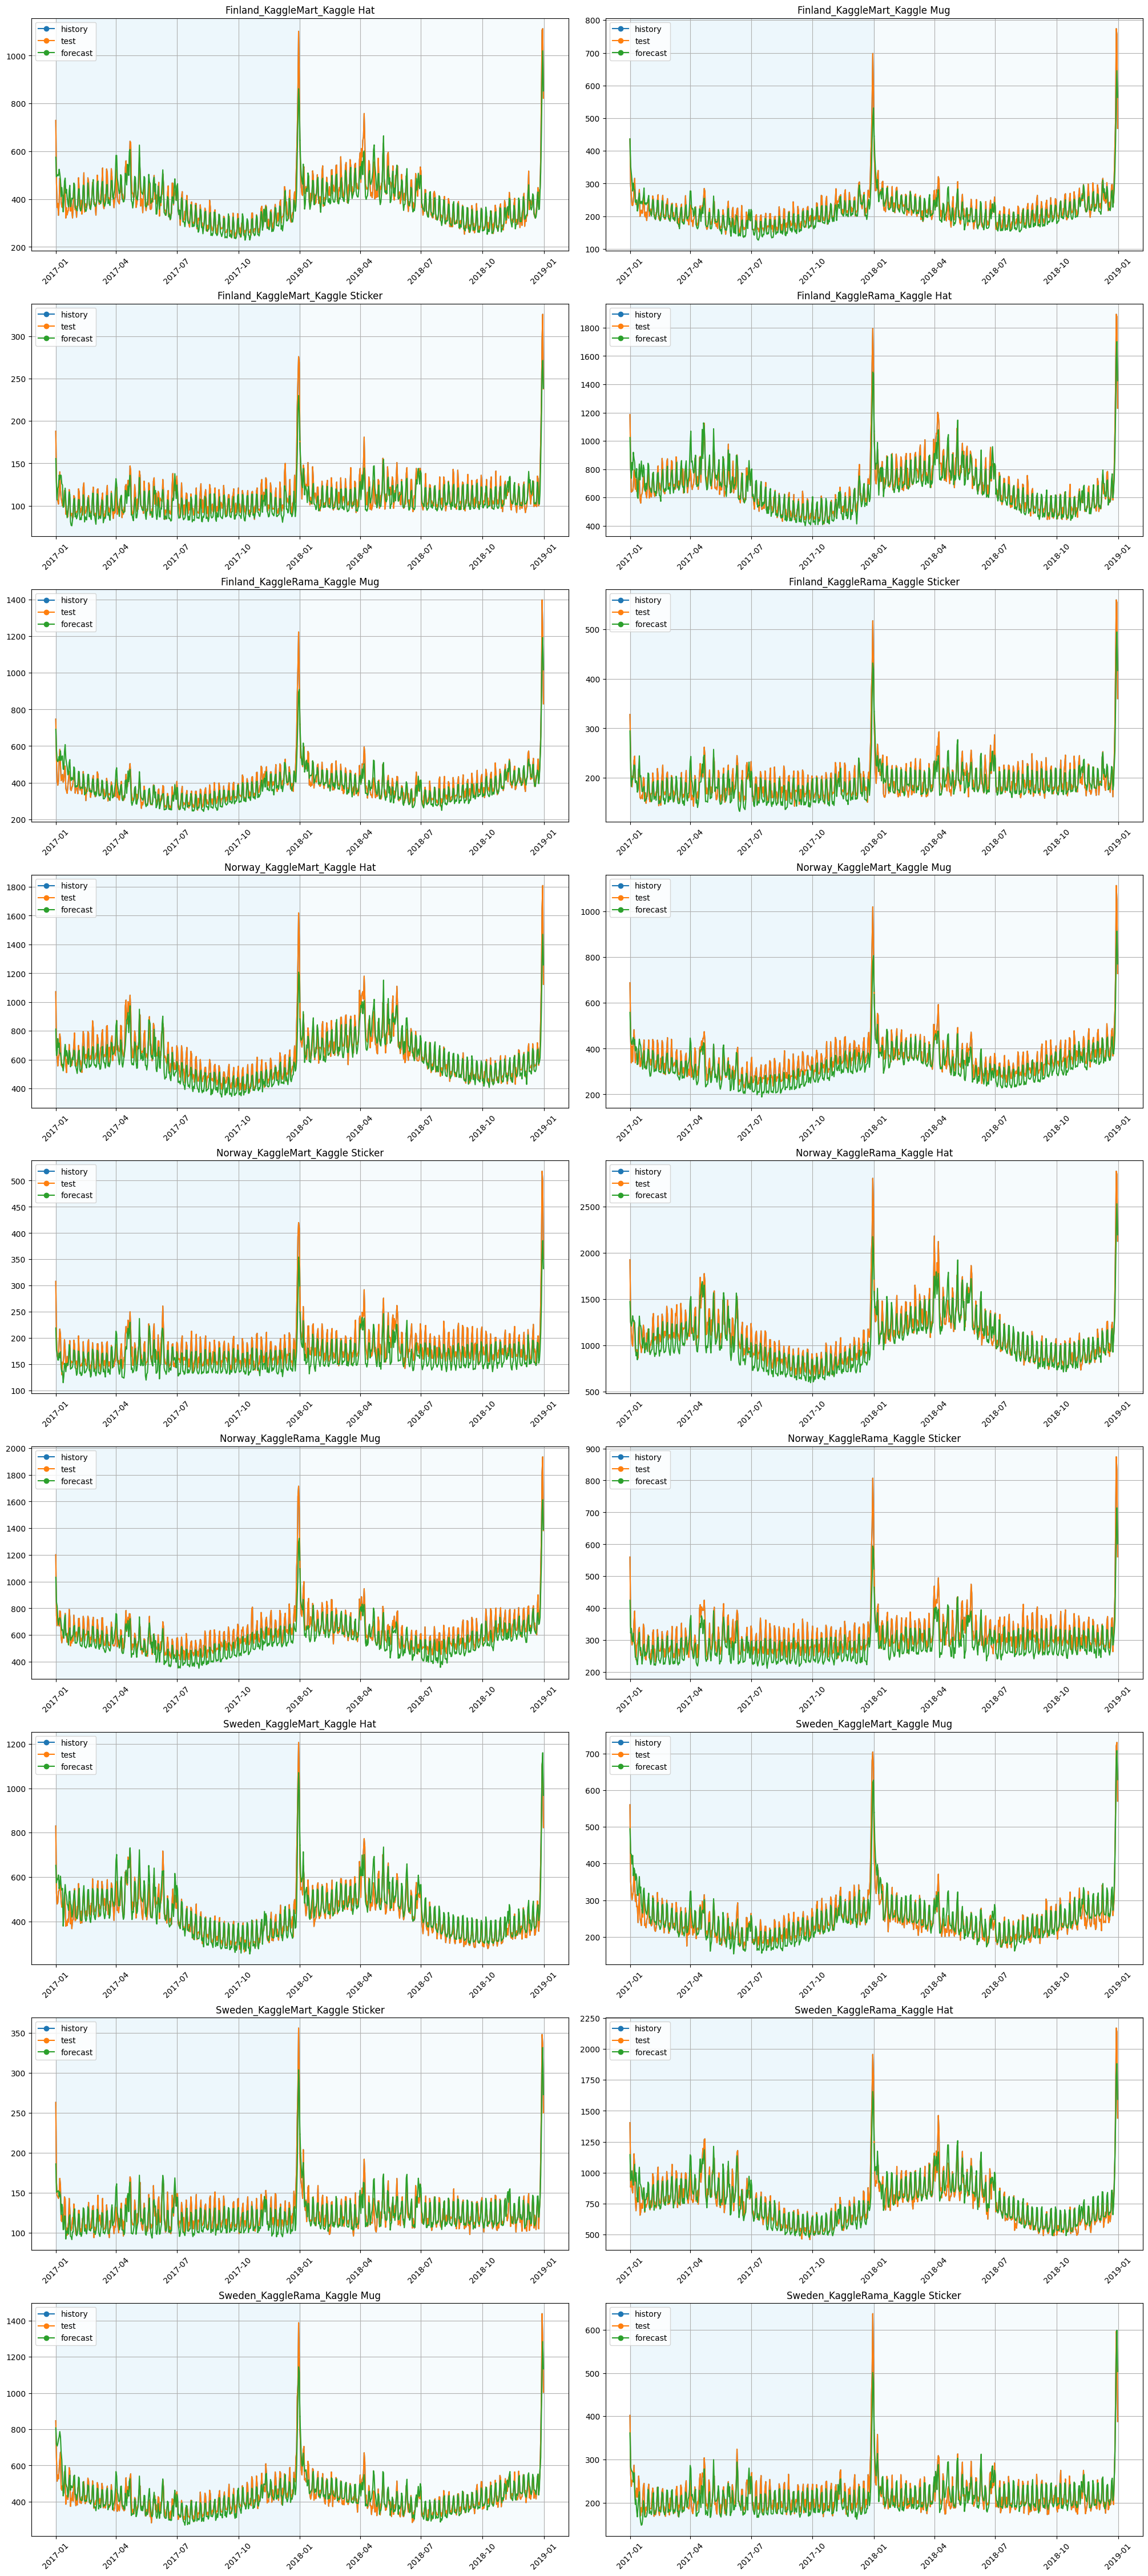

In [79]:
plot_backtest(forecasts, ts)

# 6. Ансамбли <a class="anchor" id="chapter6"></a>
[Назад к меню](#menu)

Вернемся к австралийским винам

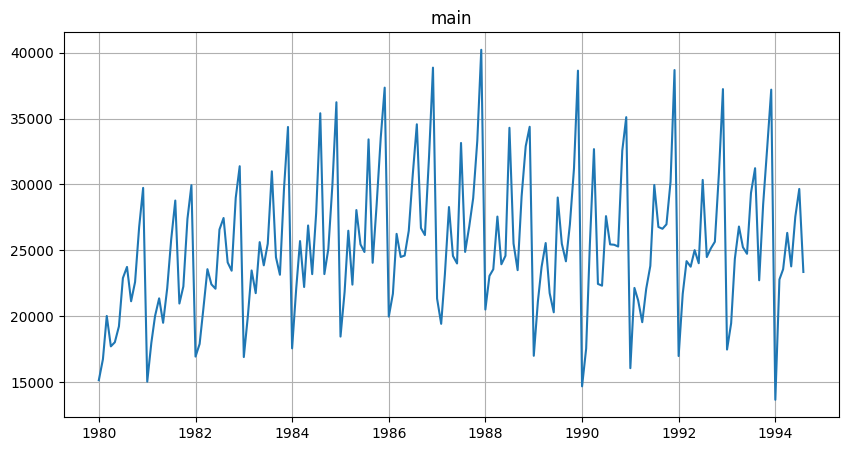

In [80]:
original_df = australian_wine.copy(deep=True)
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df=df, freq="MS")
ts.plot()

Построим несколько пайплайнов

In [81]:
HORIZON = 3
N_FOLDS = 5

naive_pipeline = Pipeline(model=NaiveModel(lag=12), transforms=[], horizon=HORIZON)

seasonalma_pipeline = Pipeline(
    model=SeasonalMovingAverageModel(window=5, seasonality=12),
    transforms=[],
    horizon=HORIZON,
)

catboost_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[LagTransform(lags=[6, 7, 8, 9, 10, 11, 12], in_column="target")],
    horizon=HORIZON,
)

pipeline_names = ["naive", "moving average", "catboost"]
pipelines = [naive_pipeline, seasonalma_pipeline, catboost_pipeline]

И посмотрим на их показатели на бэктесте

In [82]:
metrics = []
for pipeline in pipelines:
    metrics.append(
        pipeline.backtest(
            ts=ts, 
            metrics=[MAE(), MSE(), MAPE()], 
            n_folds=N_FOLDS, 
            aggregate_metrics=True, 
            n_jobs=5,)[0].iloc[:, 1:]
    )

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0526s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0472s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s remaining: 

In [83]:
metrics = pd.concat(metrics)
metrics.index = pipeline_names
metrics

MAE           MSE       MAPE
naive           2437.466667  1.089199e+07  10.222106
moving average  1913.826667  6.113701e+06   7.824056
catboost        2271.766726  8.923741e+06  10.013138

Чтобы улучшить показатели индивидуальных моделей, логично попробовать собрать их в ансамбли. Библиотека поддерживает два метода ансамблирования, с которыми мы познакомимся ниже.

### 6.1 VotingEnsemble
`VotingEnsemble` предсказывает значения как взвешенные значения прогнозов входящих в ансамбль `pipelines`.

По умолчанию веса `VotingEnsemble` **равномерны**, но мы можем задать свою развесовку вручную при помощи параметра `weights`. Излишне напоминать, что чем больше вес конкретной базовой модели, тем больше мы ей "доверяем". 

*NB*: `weights` автоматически нормируются.

In [84]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 9, 4], n_jobs=4)

In [85]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]

voting_ensamble_metrics.index = ["voting ensemble"]
voting_ensamble_metrics

[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2

MAE           MSE     SMAPE      MAPE
voting ensemble  1972.207943  6.685831e+06  8.172377  8.299714

### 6.2 StackingEnsemble
В `StackingEnsemble` поверх предсказаний индивидуальных `pipelines` обучается мета-модель.

По умолчанию `StackingEnsemble` использует только предсказания индивидуальных моделей в качестве фичей для `final_model`. Однако можно расширить этот список при помощи параметра `features_to_use`. Он может принимать следующие значения:
+ **None** - используем только предсказания индивидуальных пайплайнов (дефолтное значение)
+ **List[str]** - пресказания пайплайнов + признаки из списка
+ **"all"** - используем все возможные признаки

*NB:* В качестве дополнительных признаков из списка мы в любом случае ограничены сверху только теми, которые подаем в индивидуальные пайпланы

In [86]:
stacking_ensemble_unfeatured = StackingEnsemble(pipelines=pipelines, n_folds=10, n_jobs=4)

In [87]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]
stacking_ensamble_metrics.index = ["stacking ensemble"]
stacking_ensamble_metrics

[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3

[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   1 tasks 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   17.7s remaining:   11.8s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapse

MAE           MSE     SMAPE     MAPE
stacking ensemble  2058.487868  8.182131e+06  8.508705  8.50082

Разумеется, мы можем также отдельно специфицировать `final_model`, и в этом качестве использовать любую регрессионную модель, поддерживающую интерфейс sklearn

### 6.3 Результаты

In [88]:
metrics = pd.concat([metrics, voting_ensamble_metrics, stacking_ensamble_metrics])
metrics

MAE           MSE       MAPE     SMAPE
naive              2437.466667  1.089199e+07  10.222106       NaN
moving average     1913.826667  6.113701e+06   7.824056       NaN
catboost           2271.766726  8.923741e+06  10.013138       NaN
voting ensemble    1972.207943  6.685831e+06   8.299714  8.172377
stacking ensemble  2058.487868  8.182131e+06   8.500820  8.508705

# 7. Стратегии прогнозирования <a class="anchor" id="chapter7"></a>
[Назад к меню](#menu)

Всего возможны 5 стратегий построения прогноза:

* **Рекурсивная**: последовательно предсказываем число шагов `step`, и используем их для предсказания следующих.
* **Прямая**: используем отдельную модель для предсказания каждого подсегмента
* **DirRec**: используем отдельную модель для пресказания каждого подсегмента, при этом обучая следующую модель на датасете, в котрые добавлены прогнозы предыдущей модели
* **MIMO**: используем одну модель с множественными выходами
* **DIRMO**: MIMO + DirREC


В ETNA доступны первые две - познакомимся с ними поближе

Для этого снова вернемся к нашему старому знакомому, синтетическому многомерному ряду; заодно переопределим ряд констант

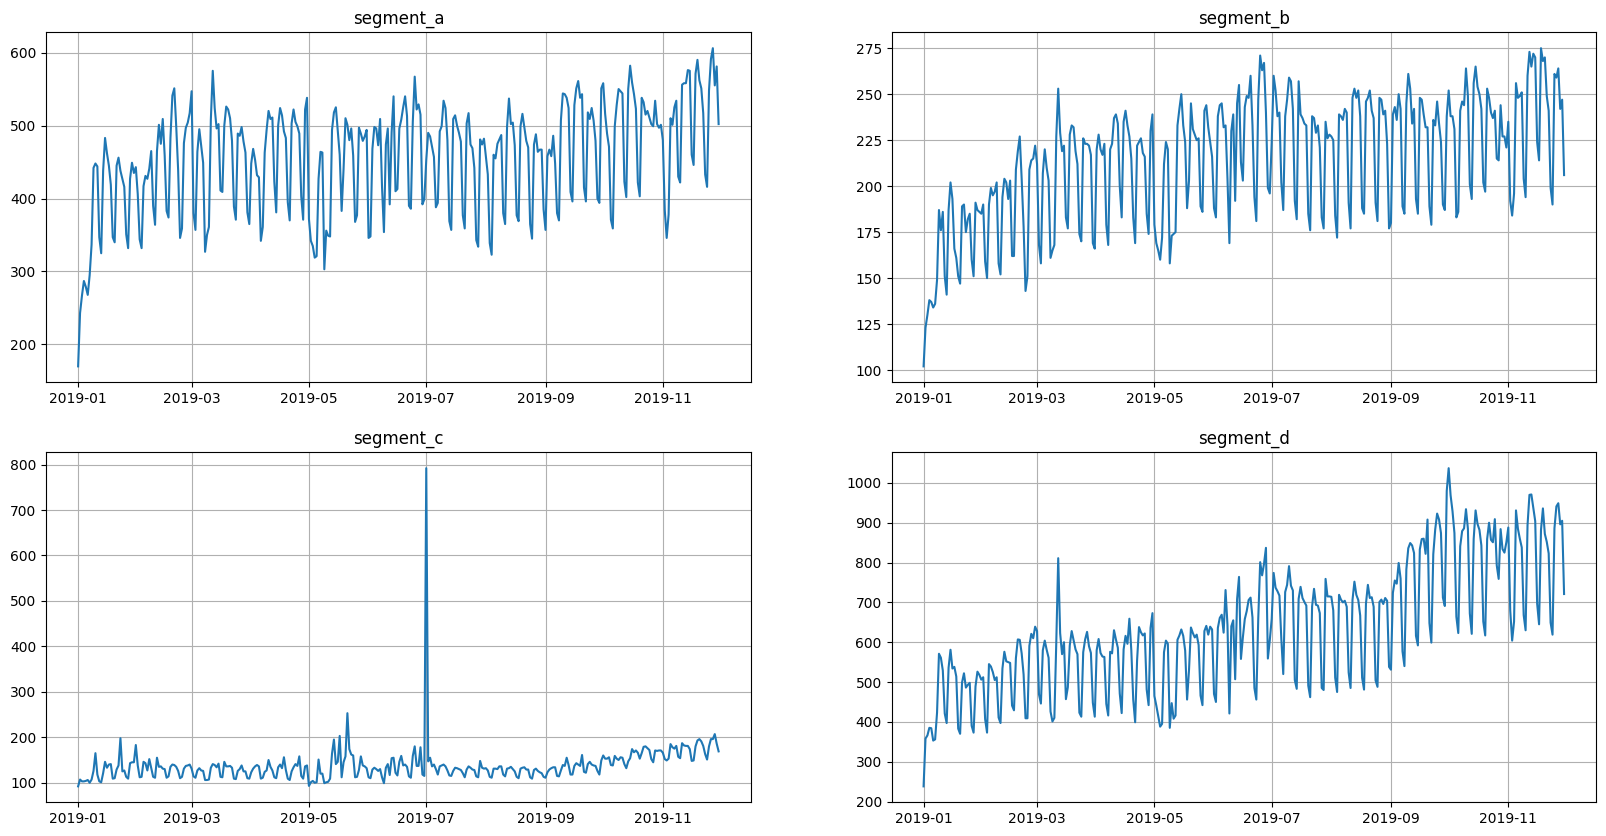

In [89]:
HORIZON = 14
HISTORY_LEN = 5 * HORIZON
NUMBER_OF_LAGS = 21

df = toy_synthetic.copy(deep=True)
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot()

## 7.1. Recursive strategy

Рекурсивная стратегия реализована при помощи класса `AutoregressivePipeline`.

### 7.1.1. AutoRegressivePipeline

`AutoRegressivePipeline` это пайплайн, который итеративно строит предсказание на `step` шагов вперед, после чего использует предсказанные значения как признаки для следующих шагов.
* Может работать медленно в случае малых значений `step`, поскольку требует пересчета признаков  $\lceil{\frac{horizon}{step}} \rceil$ раз
* Может быть неточным на больших горизонтах из-за потенциального накопления ошибки
* Позволяет использовать лаги меньше значения параметра `HORIZON`
* Является стабильным алгоритмом для рядов с высоким соотношением сигнал/шум

In [90]:
model = CatBoostModelPerSegment()

transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", 
                 lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)], 
                 out_column="target_lag"),
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, 
    transforms=transforms, 
    horizon=HORIZON, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.5s finished


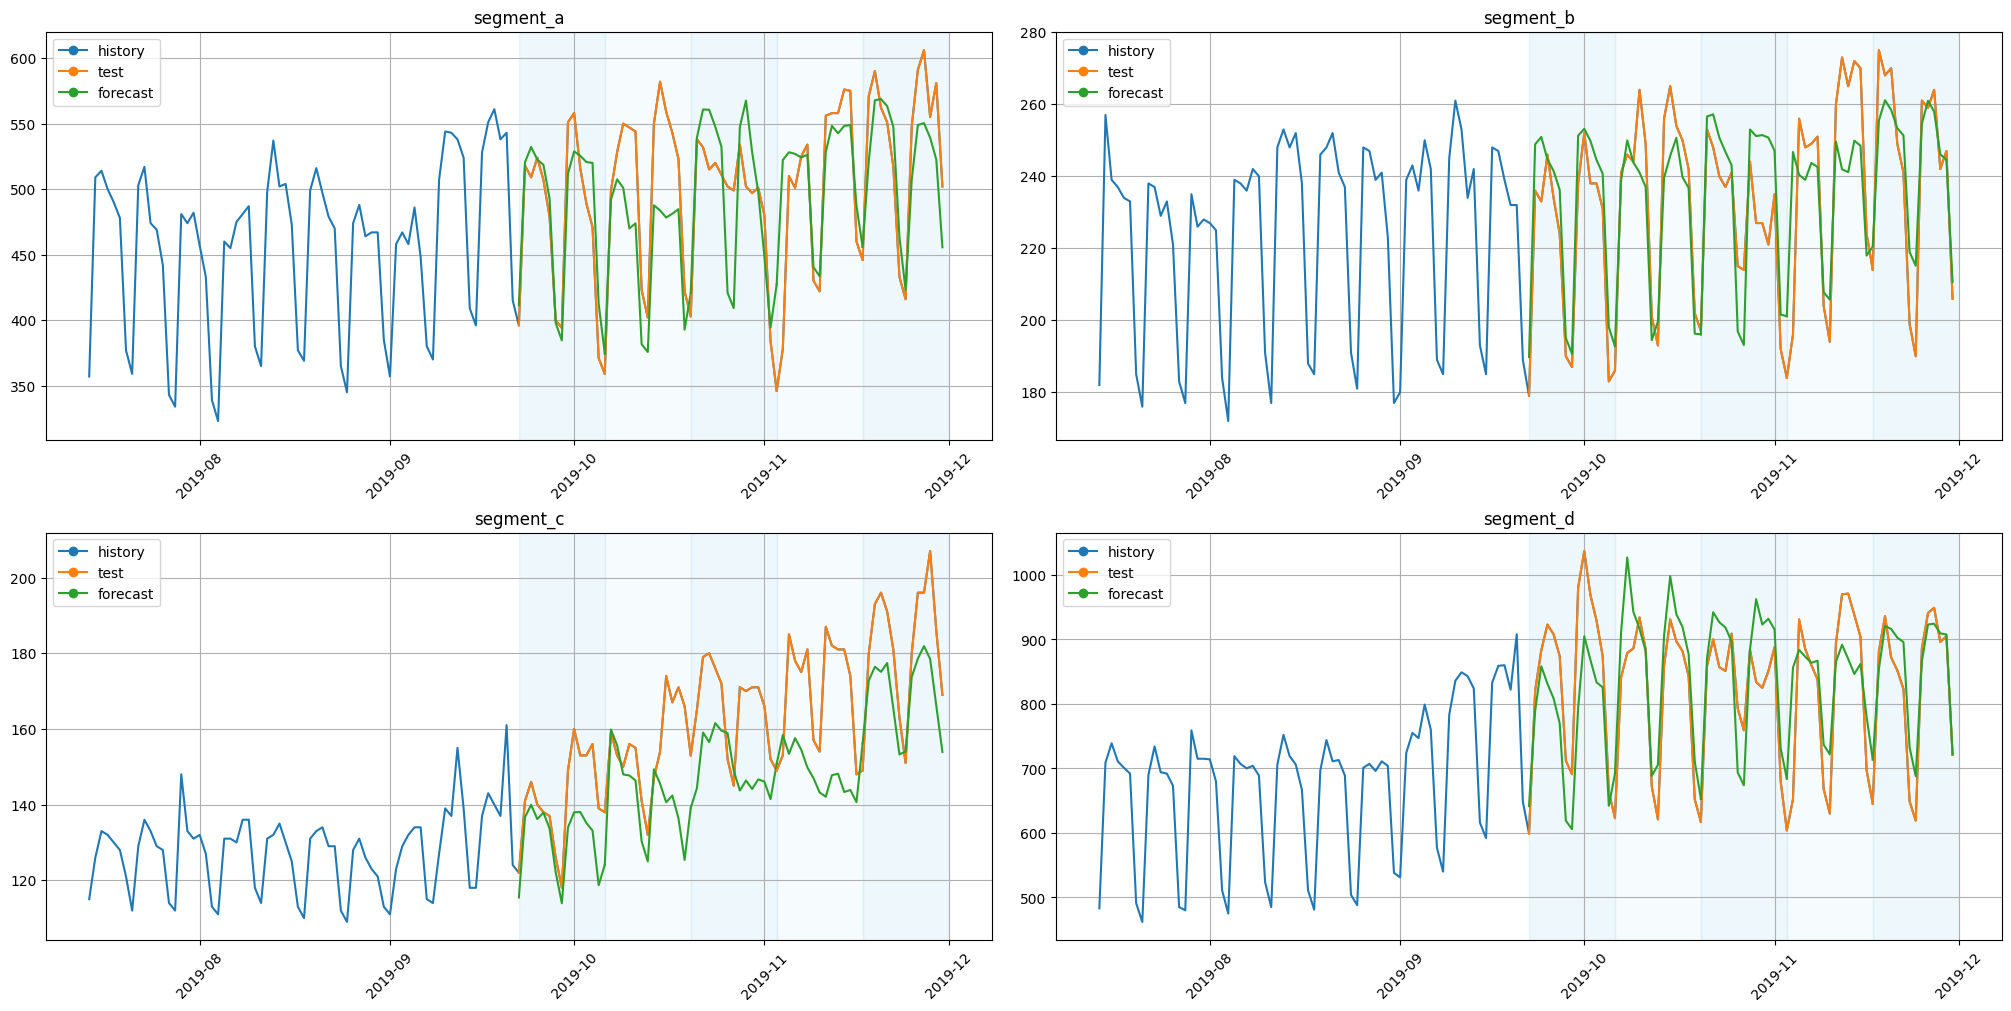

In [91]:
plot_backtest(forecast_recursive_df, ts, history_len=HISTORY_LEN)

## 7.2. Direct Strategy

Прямая стратегия в ETNA реализована при помощи классов `Pipeline` и `DirectEnsemble`. Стратегия подразумевает условную независимость прогнозов.

### 7.2.1. Pipeline

`Pipeline` реализует версию прямой стратегии, при которой всего одна модель обучается предсказывать все будущие значения. Это подразумевают следующее:

* `Pipeline` не позволяет использовать лаги со значениями меньше параметра `horizon`
* Самый быстрый метод - как на обучении, так и на инференсе
* При использовании лагов может начать терять в качестве при увеличении горизонта, так как вслед за этим возрастает ограничение снизу на длину лагов

*NB:*
Как сказано выше, мы не можем использовать лаги со значением меньше параметра `horizon`, поэтому будем использовать лаги со значениями в интервале [`horizon`, `horizon + number_of_lags`]

In [92]:
model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target", 
        lags=list(range(HORIZON, HORIZON + NUMBER_OF_LAGS)), 
        out_column="target_lag"),
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

metrics_pipeline_df, forecast_pipeline_df, _ = pipeline.backtest(
    ts=ts, 
    metrics=[SMAPE(), MAE(), MAPE()]
)

pipeline_metrics = metrics_pipeline_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.8s finished


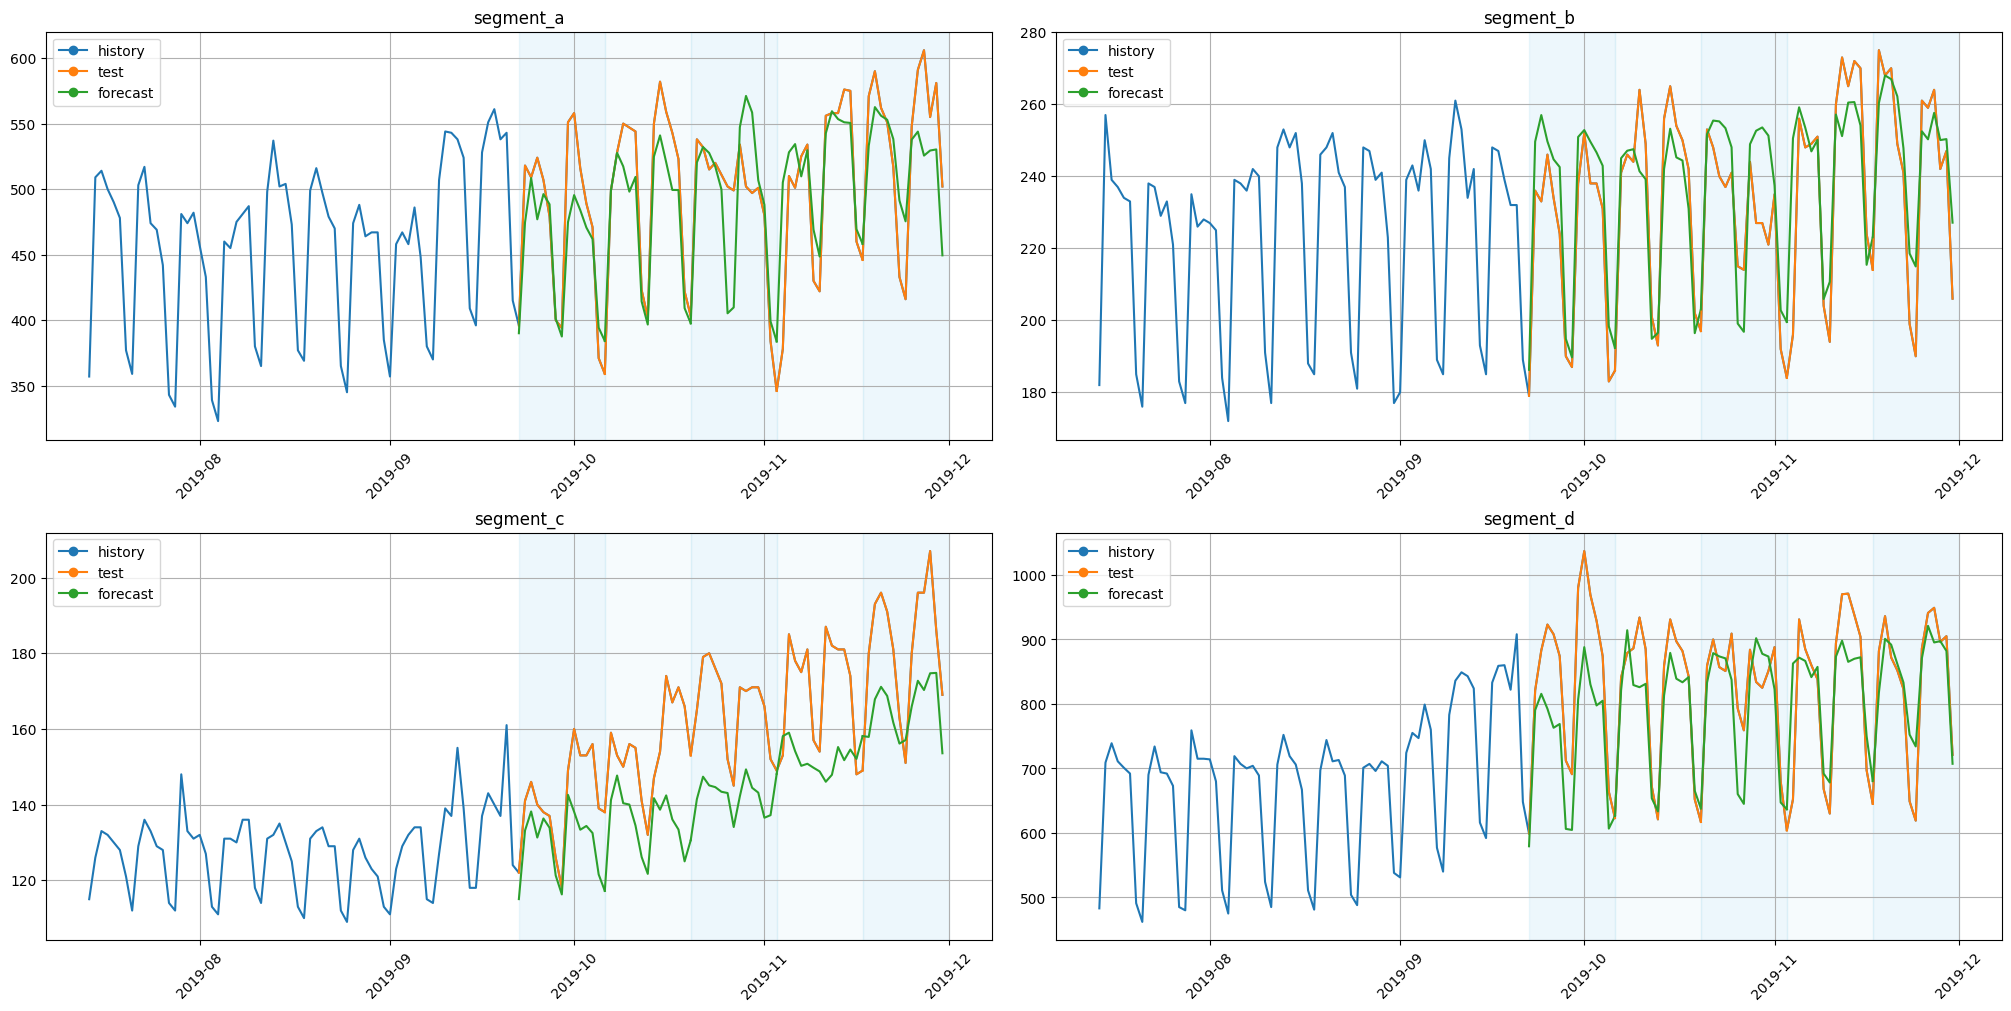

In [93]:
plot_backtest(forecast_pipeline_df, ts, history_len=HISTORY_LEN)

### 7.2.2. DirectEnsemble 

`DirectEnsemble` обучает отдельный пайплайн для каждого подсегмента. При построении предсказания, метод выбирает в качестве базового пайплайн с наиболее коротким горизонтом, который при этом покрывает текущую предсказываемую точку. Более наглядно процесс представлен на иллюстрации

![title](./data/ensemle.png)



* Метод может быть крайне полезен когда мы располагаем несколькими разными пайплайнами, каждый из которых эффективен на своем горизонте
* Скорость вычисления падает по мере увеличения количества базовых пайплайнов.
* Прогноз при использовании данной стратегии может выглядеть как ломаная кривая / кривая с разрывами, поскольку составные части прогноза получены из независимых моделей

#### Пример
В качестве примера, зададим отдельный пайплайн для каждой интересующей нас недели. Первую неделю будем предсказывать с использованием лагов в интервале [`7`, `7 + number_of_lags`], вторую - с использованием лагов в интервале [`horizon`, `horizon + number_of_lags`]. Мы, таким образом, ожидаем, что использование более близких лагов для первой недели улучшит качество предсказания. 

Начнем со спецификации пайплайнов:

In [94]:
horizons = [7, 14]

model_1 = CatBoostModelPerSegment()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target", 
        lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)], 
        out_column="target_lag"
    ),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = CatBoostModelPerSegment()
transforms_2 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target", 
        lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)], 
        out_column="target_lag"
    ),
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

Следующим шагом объединим их в ансамбль и сделаем прогноз:

In [95]:
ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(
    ts=ts, 
    metrics=[SMAPE(), MAE(), MAPE()]
)

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

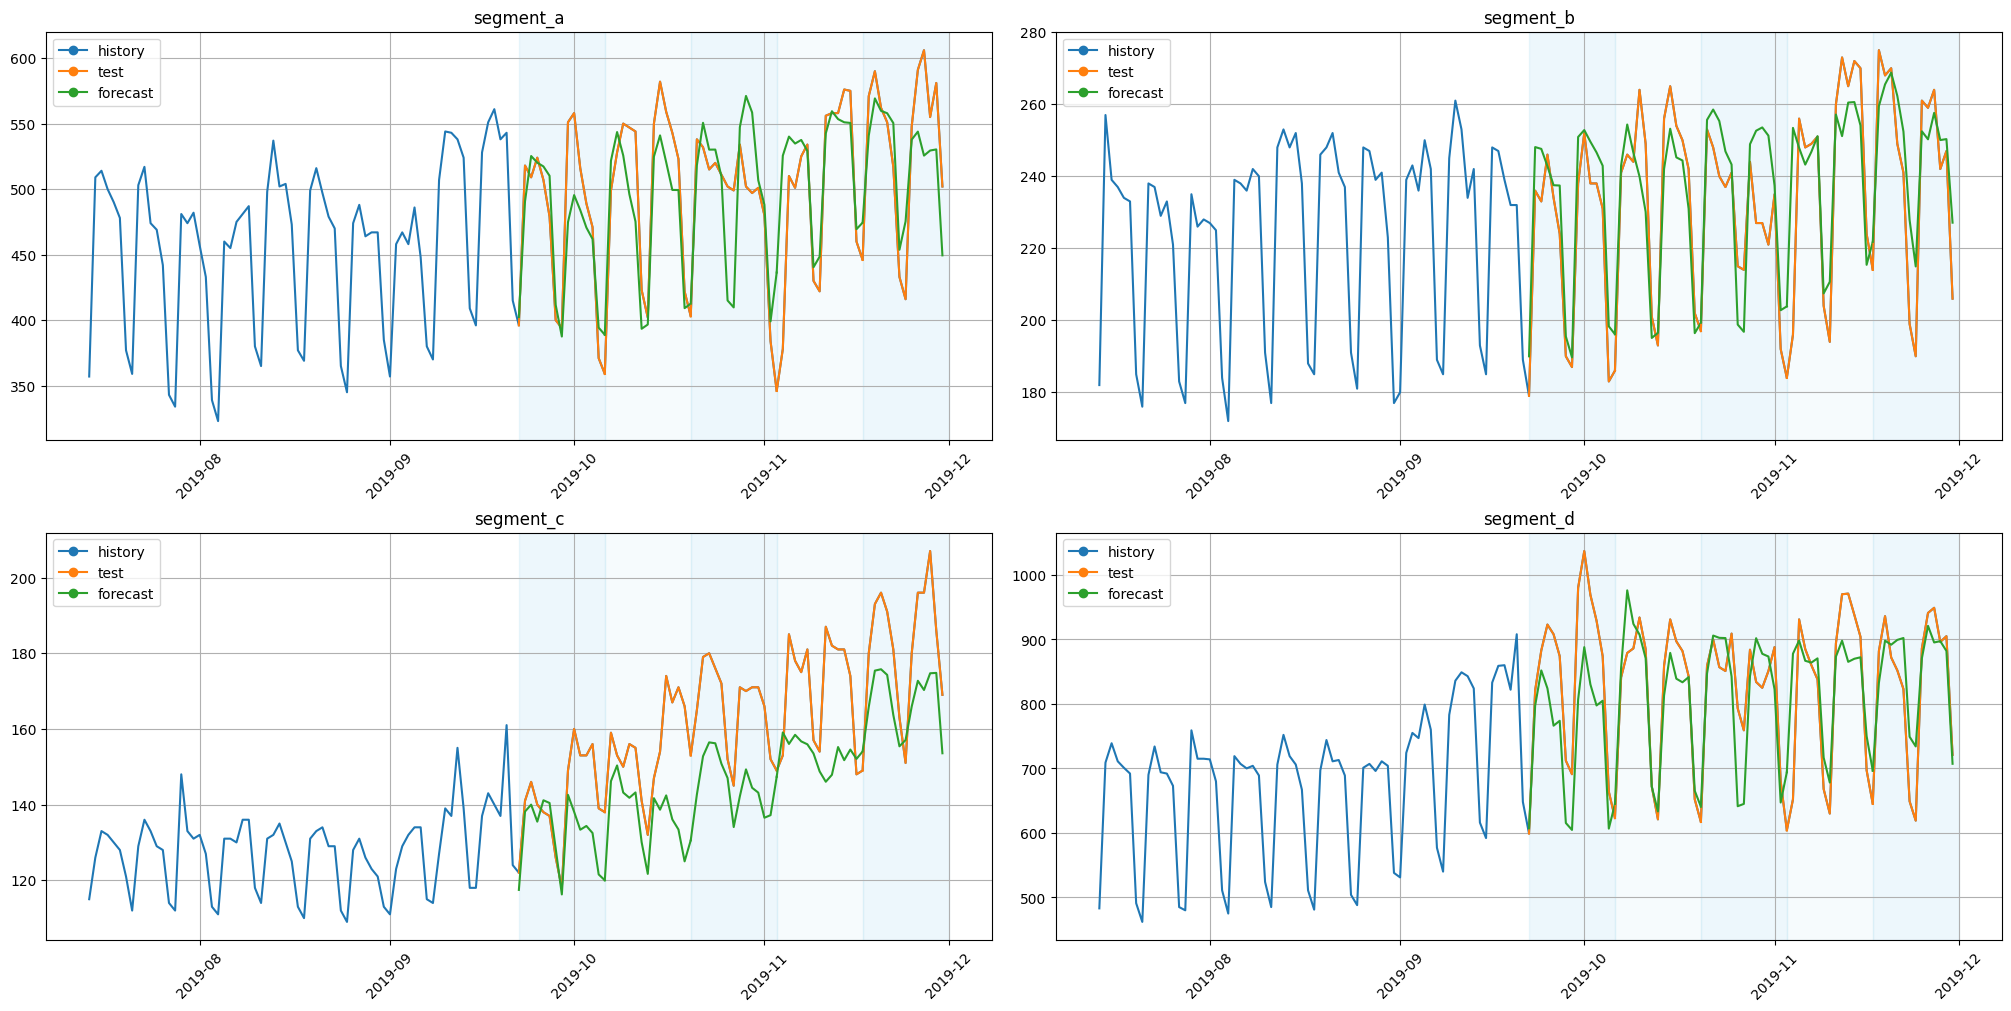

In [96]:
plot_backtest(forecast_ensemble_df, ts, history_len=HISTORY_LEN)

### 7.2.3. assemble_pipelines с DirectEnsemble

Поскольку задание `DirectEnsemble` может подразумевать создание множества схожих пайплайнов (отличающихся лишь немногоми аспектами), для повышения эффективности процесса можно использовать `assemble_pipelines`. В этом случае генерация пайплайнов происходит следующим образом:

1. Модели (горизонты) могут задаваться как одна модель (горизонт), или же как последовательность моделей (горизонтов) Мэппинг `i`-го пайплайна к `i`-й модели(горизонту) произойдет автоматически. 
2. Преобразования (transforms) могут задаватся как последовательность преобразований или последовательность последовательностей преобразований. Взгляанем на несколько примеров вариантов того, что может происходить с преобразованиями:

Предположим `A`, `B`, `C`, `D`, `E` различные преобразования (transforms).

#### Пример 1

Если последовательность преобразований задается как `[A, B, C]`,  `[A, B, C]` будут применены к каждому пайплайну

#### Пример 2

Если последовательность преобразований задается как `[A, [B, C], D, E]`,  `[A, B, D, E]` будут применены к первому пайплайну и `[A, C, D, E]` ко второму.

#### Пример 3

Если последовательность преобразований задается как `[A, [B, C], [D, E]]`, `[A, B, D]` будут применены к первому пайплайну и `[A, C, E]` ко второму.

#### Пример 4

Если последоваельность преобразований задается как `[A, [B, None]]`, `[A, B]` будут применены к первому пайплайну, и `[A]` ко второму.


Давайте перестроим ансамбль из предыдущего раздела при помощи `assemble_pipelines`

In [97]:
models = [CatBoostModelPerSegment(), CatBoostModelPerSegment()]
transforms = [
    LinearTrendTransform(in_column="target"),
    [
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),
    ],
]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], out_column = 'target_lag', )], horizon = 7, ),
 Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], out_column = 'target_lag', )], horizon = 14, )]

Генерация пайплайнов, кажется, действительно упростилась. Обернем их в `DirectEnsemble`:

In [98]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_ensemble_df_2, forecast_ensemble_df_2, _ = ensemble.backtest(
    ts=ts, 
    metrics=[SMAPE(), MAE(), MAPE()]
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

Проверка того, что прогноз (ожидаемо) не поменялся:

In [99]:
pd.testing.assert_frame_equal(metrics_ensemble_df_2, metrics_ensemble_df)

## 7.3. Результаты

В этой секции мы обсудили стратегии построения прогноза в ETNA, с примерами. В завершение, сравним качество стратегий, которые мы обсудили, на искомом датасете:

In [100]:
df_res = pd.DataFrame(
    data=[ensemble_metrics, pipeline_metrics, autoregressive_pipeline_metrics],
    index=["direct_ensemble", "pipeline", "autoregressive_pipeline"],
).drop("fold_number", axis=1)

df_res = df_res.sort_values(by="SMAPE")
df_res

SMAPE        MAE      MAPE
direct_ensemble          7.152913  28.657613  7.004382
autoregressive_pipeline  7.247425  29.945816  7.117746
pipeline                 7.319264  28.476013  7.102676